In [1]:
import matplotlib.pyplot as plt
import random, shutil, pickle, sys
import numpy as np
from collections import deque
from keras import Sequential
from keras.optimizers import RMSprop
from IPython.display import display
from PIL import Image
import pandas as pd
from keras import Model
import keras, os, glob
import tensorflow as tf
from keras.layers import Layer, Dense, Conv2D, Flatten, RepeatVector,Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from keras.layers import Activation, LSTM, Bidirectional , Dropout
from keras import layers
# import cv2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import codecs
import csv
import secrets
import sqlite3
from IPython.display import display
from IPython.display import clear_output
import time
from tabulate import tabulate
import json
import datetime

In [2]:
m5long = pd.read_csv("final_m5long.csv")
m5short = pd.read_csv("final_m5short.csv")
m1long = pd.read_csv("final_m1long.csv")
m1short = pd.read_csv("final_m1short.csv")

In [5]:
import numpy as np
from PIL import Image
import pandas as pd
#this function returns the position of ask and bid lines in an image that will be used as markers of where to start to draw
def get_ask_bid_lines(image_path):
    ask_bid_lines = {"ask_line":None, "bid_line":None, "key": 0}
    img = Image.open(image_path)
    img_data = np.array(img)
    # print(img_data.shape)
    last_part = Image.fromarray(img_data[:,200:201,:])
    # display(last_part)
    img1_pixels = last_part.load()
    ask_color = (255,0,0)
    bid_color = (119, 136, 153)

    for y in range(224):
        if img1_pixels[0,y] == ask_color:
            ask_bid_lines["ask_line"] = y
            # print(y)
        if img1_pixels[0,y] == bid_color:
            ask_bid_lines["bid_line"] = y
            # print(y)
    return ask_bid_lines , img

In [6]:
#image data tests
dataset_directory  = "colabM1M5/episode2/"
m1short = pd.read_csv("final_m1short.csv")
test_lines = get_ask_bid_lines(f"{dataset_directory}{m1short.iloc[0]['image_path']}")
ask_bid_lines = {"ask_line":None, "bid_line":None}
print(test_lines)
assert(test_lines == test_lines)
# assert(False,ask_bid_lines == test_lines)


({'ask_line': 103, 'bid_line': 107, 'key': 0}, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7F267BD235D0>)


start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
png0


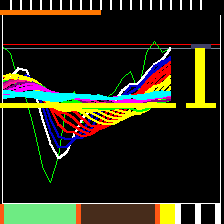

In [292]:
from PIL import Image, ImageDraw
def draw_entry_trade(img2):
    pass

def reset_chart(img, draw_context):
    # Define the coordinates of the black bar
    x1, y1 = 0, 204
    x2, y2 = 200, 224
    # Draw the black bar bottom bar
    draw_context.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))
    # Draw the black bar top bar
    x1, y1 = 0, 0
    x2, y2 = 224, 14
    draw_context.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))
    
    
def draw_account_balance(img, draw_context,balance_limit = 300, account_balance = 1000, standard_balance = 1000):
    balance = balance_limit + (account_balance - standard_balance)
    if balance == balance_limit:
        x1, y1 = 3, 204
        x2, y2 = 75 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131))
    
    elif balance < balance_limit:
        health_bar = int((balance * 75) / balance_limit )
        lost_bar = 75 - health_bar
        #current_balnace
        x1, y1 = 3, 204
        x2, y2 = health_bar, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131))
        #lost bar
        x1, y1 = health_bar, 204
        x2, y2 = 75 , 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 0, 0))
    elif balance > balance_limit:
        x1, y1 = 3, 204
        x2, y2 = 75 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131)) 
        #Draw the profit section on account_bar
        profit = int(((balance - balance_limit) * 75) / balance_limit)
        
        x1, y1 = 80, 204
        x2, y2 = 80 + profit , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(71, 44, 27)) 
    
    #draw start separator
    #draw Account Separator and end separator
    x1, y1 = 0, 204
    x2, y2 = 3 , 224
    # Draw the green bar for account
    draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20))     
    
    #draw Account Separator and end separator
    x1, y1 = 76, 204
    x2, y2 = 80 , 224
    # Draw the green bar for account
    draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20)) 
    
    #draw Account Separator and end separator
    x1, y1 = 155, 204
    x2, y2 = 160 , 224
    # Draw the green bar for account
    draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20)) 

def draw_current_trade(img, draw_context, position=None):
    if position == "buy":
        x1, y1 = 160, 204
        x2, y2 = 175, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 0)) 
    elif position == "sell":
        x1, y1 = 180, 204
        x2, y2 = 195, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(0, 255, 0))  
    else:
        x1, y1 = 200, 204
        x2, y2 = 215, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255,0,255)) 
        
    #Draw position separator icons
    x1, y1 = 175, 204
    x2, y2 = 180, 224
    draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
    x1, y1 = 195, 204
    x2, y2 = 200, 224
    draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
    x1, y1 = 215, 204
    x2, y2 = 220, 224
    draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
    
def draw_profit_bar(img, draw_context, profit = 0, account_balance = 1000):
    pnl_parts = int(abs(profit) / 10)
    for segment in range(0, 200, 10):
        f = segment + 10
        x1, y1 = segment+10, 0
        x2, y2 = f + 1, 9
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
        #display profit on the chart
        if profit > 0 and pnl_parts > 0 and segment >= 100:
            print(f"parts {pnl_parts} ")
            if segment < pnl_parts * 10 + 100:
                x1, y1 = segment, 0
                x2, y2 = segment + 10, 9
                draw_context.rectangle([x1, y1, x2, y2], fill=(27, 152, 224)) 
        elif profit < 0 and pnl_parts > 0 and segment <= 90 and segment >= 100 - abs(profit):
#           
            x1, y1 = segment, 0
            x2, y2 = segment + 10, 9
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 0, 0))  
        
        account_balance_bar = (200*account_balance)/2000
        x1, y1 = 0, 10
        x2, y2 = account_balance_bar, 14
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 119, 0)) 
            
    # print(f"Profit {}")
    print(f"png{pnl_parts}")
        
def draw_buy_bar(img2, start_lines, end_lines, position = None, profit = 0, prev_trade=None, balance_limit = 300, account_balance = 1100, standard_balance = 1000):
    print(f"start lines{start_lines}")
    print(f"end lines{end_lines}")
    from PIL import Image, ImageDraw
    d = ImageDraw.Draw(img2)
    reset_chart(img2, d)
    draw_account_balance(img2, d, balance_limit, account_balance, standard_balance)
    
    if position == "sell":
        #draw icon for trade setup
        draw_current_trade(img2, d, "sell")
        # Draw indicator of trade start
        line_color = (200,200,200)
        top = (200, end_lines["ask_line"])
        bottom = (200, end_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=20)
        
        #Draw start marker and line
        line_color = (0, 255, 0)
        top = (200, start_lines["ask_line"])
        bottom = (200, start_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=30) 
        #Draw start line
        line_color = (0, 255, 0)#(252, 81, 48)
        top = (50, start_lines["ask_line"])
        bottom = (50, start_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=250) 
        
        #Draw profit indicator of sell
        if profit < 0:
            line_color = (255, 0, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200,end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10)
        else:
            line_color = (0, 255, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200,end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10)
        #Draw loss indicator for sell
        draw_profit_bar(img2, d, profit)
    elif position == "buy":
        #draw bottom right trade status sell , buy , close
        draw_current_trade(img2, d, "buy") # 
        #Draw indicator of trade start
        #Draw end marker
        line_color = (65, 64, 102)
        top = (200, end_lines["ask_line"])
        bottom = (200, end_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=20) 
        
        #Draw start marker for buy
        line_color = (255, 255, 0)
        top = (200, start_lines["ask_line"])
        bottom = (200, start_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=30) 
        
        #Draw start buy line across the chart
        line_color = (255, 255, 0)#(255,0,200)
        top = (50, start_lines["ask_line"])
        bottom = (50, start_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=250)         
        
        
        if profit < 0:
            line_color = (255, 0, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10)
        else:
            line_color = (255, 255, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10)
        draw_profit_bar(img2, d, profit)
    elif position == "close" and prev_trade == None:
        draw_current_trade(img2, d, "close")
        line_color = (255,0,255)
        top = (200, end_lines["ask_line"])
        bottom = (200, end_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=30)  
        
        draw_profit_bar(img2, d, profit)
    else:
        #draw main vertical bar
        draw_current_trade(img2, d, "close")
        line_color = (255,0,255)
        top = (200, start_lines["ask_line"])
        bottom = (200, end_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=15)
        #draw end bar
        line_color = (255,0,255)
        top = (200, end_lines["ask_line"])
        bottom = (200, end_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=30) 
        #Draw start marker and line
        line_color = (255,0,255)
        top = (200, start_lines["ask_line"])
        bottom = (200, start_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=30)
        
        line_color = (2, 8, 135)
        top = (50, start_lines["ask_line"])
        bottom = (50, start_lines["bid_line"])
        d.line([top, bottom], fill=line_color, width=250)
        draw_profit_bar(img2, d, profit)
        
        if prev_trade == "sell" and profit > 0:   
            #print right bar for the trade that has closed
            line_color = (0, 255, 0)
            top = (213, start_lines["ask_line"])
            bottom = (213, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10) 
            
            line_color = (241, 254, 198)
            top = (190, start_lines["ask_line"])
            bottom = (190, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10)             
            
        elif prev_trade == "sell" and profit < 0:
            line_color = (0, 255, 0)
            top = (213, start_lines["ask_line"])
            bottom = (213, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10) 
            
            line_color = (255,0,0)
            top = (190, start_lines["ask_line"])
            bottom = (190, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10)    
        elif prev_trade == "buy" and profit > 0:
            line_color = (255, 255, 0)
            top = (213, start_lines["ask_line"])
            bottom = (213, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10) 
            
            line_color = (241, 254, 198)
            top = (190, start_lines["ask_line"])
            bottom = (190, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10)    

  
            
        elif prev_trade == "buy" and profit < 0:
            line_color = (255, 255, 0)
            top = (213, start_lines["ask_line"])
            bottom = (213, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10) 
            
            line_color = (255,0,0)
            top = (190, start_lines["ask_line"])
            bottom = (190, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=10) 
        
    display(img2)
    return img2

ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="buy" , profit = 0, balance_limit = 300, account_balance = 1300, standard_balance = 1000)

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
png4


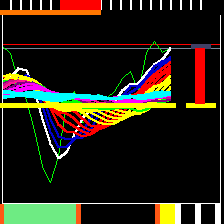

In [281]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="buy" , profit = -40)

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
png4


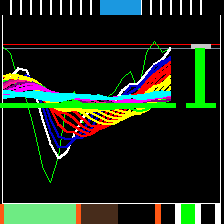

In [248]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="sell" , profit = 40)

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
png4


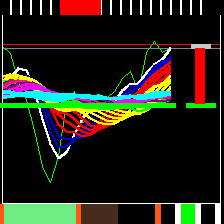

In [253]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="sell" , profit = -40)

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
png4


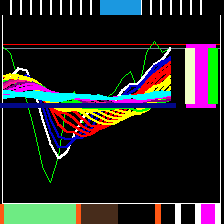

In [254]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="close" , profit = 40, prev_trade = "sell")

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
png4


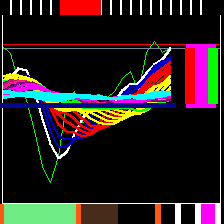

In [240]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="close" , profit = -40, prev_trade = "sell")

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
parts 4 
png4


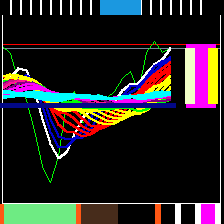

In [255]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="close" , profit = 40, prev_trade = "buy")

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
png4


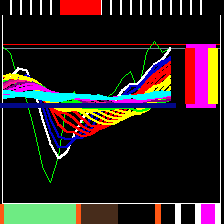

In [242]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="close" , profit = -40, prev_trade = "buy")

start lines{'ask_line': 103, 'bid_line': 107, 'key': 0}
end lines{'ask_line': 44, 'bid_line': 48, 'key': 0}
png0


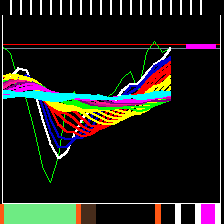

In [266]:
ask_bid1 , img1 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
ask_bid2 , img2 = get_ask_bid_lines("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img2 = draw_buy_bar(img2, ask_bid1, ask_bid2, position="close" , profit = 0, prev_trade = None, balance_limit = 1000, balance = 1200)

In [ ]:


# def display_row_images(long_short_dict_now , long_short_dict_next):
from collections import deque
trade_queue = deque(maxlen=4)

image_queue = deque(maxlen=4)
dataset_directory  = "colabM1M5/episode2/"
action = 1
active_trade = None

linesq, imageq = get_ask_bid_lines(f"{dataset_directory}{m1short.iloc[4-4]['image_path']}")
linesq["key"] = 0
linest, imaget = get_ask_bid_lines(f"{dataset_directory}{m1short.iloc[4-3]['image_path']}")
linest["key"] = 1
liness, images = get_ask_bid_lines(f"{dataset_directory}{m1short.iloc[4-2]['image_path']}")
liness["key"] = 2
linesc, imagec = get_ask_bid_lines(f"{dataset_directory}{m1short.iloc[4-3]['image_path']}")
linesc["key"] = 3

trade_queue.append(linesq)
trade_queue.append(linest)
trade_queue.append(liness)
trade_queue.append(linesc)

image_queue.append(imageq)
image_queue.append(imaget)
image_queue.append(images)
image_queue.append(imagec)

# # Calculate the required dimensions for the new image
new_width = imageq.width * 4
new_height = imageq.height
# # Create a new image with the required dimensions
new_image = Image.new("RGB", (new_width, new_height))
# # Paste the individual images side by side
new_image.paste(imageq, (0, 0))
new_image.paste(imaget, (imageq.width, 0))
new_image.paste(images, (imageq.width + imaget.width, 0))
new_image.paste(imagec, (imageq.width + imaget.width + images.width, 0))
# # Display the final imagem5short_image_path
def reset_collection(t_q, i_q):
    _queue = deque(maxlen=4)
    for i in range(0, 4):
        _lines_c, _image_c = get_ask_bid_lines(f"{dataset_directory}{m1short.iloc[t_q[i]['key']]['image_path']}")
        _image_c = draw_buy_bar(_image_c, _lines_c, _lines_c, position="close", profit = 0)
        _queue.append(_image_c)
    return t_q, _queue
def draw_collection(q):
    # # Calculate the required dimensions for the new image
    new_width = q[0].width * 4
    new_height =q[0].height
    # # Create a new image with the required dimensions
    new_image = Image.new("RGB", (new_width, new_height))
    # # Paste the individual images side by side
    new_image.paste(q[0], (0, 0))
    new_image.paste(q[1], (q[0].width, 0))
    new_image.paste(q[2], (q[0].width + q[0].width, 0))
    new_image.paste(q[3], (q[0].width + q[0].width + q[0].width, 0))
    display(new_image) 

position = None
action = 1
current_trade = {}
current_trade["start_index"] = None
current_trade["bid_ask_lines"] = None
current_trade["entry_price"] = None
current_trade["current_price"] = None
ticks = [ 0,0,0,0,1,1,1,1,1,1,1,0,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1, 0, 2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
for i in range(4, 1000):
    action = ticks[i]
    print(f"Action {action}")
    lines_current, image_current = get_ask_bid_lines(f"{dataset_directory}{m1short.iloc[i-0]['image_path']}")
    lines_current["key"] = i
    
    if position == None:
        if action == 1:
            position = "buy"
            current_trade["start_index"] = i
            current_trade["bid_ask_lines"] = lines_current
            current_trade["entry_price"] = float(f"{m1short.iloc[i]['Ask']}")
            image_current = draw_buy_bar(image_current, lines_current, lines_current, position="buy" , profit = 0)
            trade_queue.append(lines_current)
            image_queue.append(image_current)  
            draw_collection(image_queue)
            
            
        elif action == 2:
            position = "sell"
            current_trade["start_index"] = i
            current_trade["bid_ask_lines"] = lines_current
            current_trade["entry_price"] = float(f"{m1short.iloc[i]['Bid']}")
            image_current = draw_buy_bar(image_current, lines_current, lines_current, position="sell", profit = 0)
            trade_queue.append(lines_current)
            image_queue.append(image_current)  
            draw_collection(image_queue)
        
        elif action == 0:
            position = None
            current_trade["start_index"] = None
            current_trade["bid_ask_lines"] = None
            current_trade["entry_price"] = None
            image_current = draw_buy_bar(image_current, lines_current, lines_current, position="close", profit = 0)
            trade_queue.append(lines_current)
            image_queue.append(image_current)  
            draw_collection(image_queue)            
                              
    
    if position == "buy":
        if action == 1:
            current_trade["current_price"] = float(f"{m1short.iloc[i]['Ask']}")
            image_current = draw_buy_bar(image_current, current_trade["bid_ask_lines"], lines_current, position="buy" , profit = current_trade["current_price"] - current_trade["entry_price"])
            trade_queue.append(lines_current)
            image_queue.append(image_current)
            draw_collection(image_queue)
            
        # elif action == 2:
        #     pass
        elif action in [0,2]:
            current_trade["current_price"] = float(f"{m1short.iloc[i]['Bid']}")
            image_current = draw_buy_bar(image_current, current_trade["bid_ask_lines"], lines_current, position="close", profit= current_trade["current_price"] - current_trade["entry_price"])
            trade_queue.append(lines_current)
            image_queue.append(image_current)
            draw_collection(image_queue)
            
            #reset image queue
            trade_queue, image_queue = reset_collection(trade_queue,image_queue)
            
            current_trade = {}
            current_trade["start_index"] = None
            current_trade["bid_ask_lines"] = None
            current_trade["entry_price"] = None
            current_trade["current_price"] = None
            position = None
            pass
    elif position == "sell":
        if action == 2:
            current_trade["current_price"] = float(f"{m1short.iloc[i]['Ask']}")
            image_current = draw_buy_bar(image_current, current_trade["bid_ask_lines"], lines_current, position="sell", profit = current_trade["entry_price"] - current_trade["current_price"])
            trade_queue.append(lines_current)
            image_queue.append(image_current)
            draw_collection(image_queue)
        # elif action == 1:
        #     pass
        elif action in [1,0]:
            current_trade["current_price"] = float(f"{m1short.iloc[i]['Ask']}")
            image_current = draw_buy_bar(image_current, current_trade["bid_ask_lines"], lines_current, position="close", profit= current_trade["entry_price"] - current_trade["current_price"])
            trade_queue.append(lines_current)
            image_queue.append(image_current)
            draw_collection(image_queue)
            
            #reset image queue
            trade_queue, image_queue = reset_collection(trade_queue,image_queue)
            
            current_trade = {}
            current_trade["start_index"] = None
            current_trade["bid_ask_lines"] = None
            current_trade["entry_price"] = None
            current_trade["current_price"] = None
            position = None
            pass
        
    print(f"LAST {i-3} {dataset_directory}{m1short.iloc[i-3]['image_path']}")
    print(f"THRD {i-2} {dataset_directory}{m1short.iloc[i-2]['image_path']}")
    print(f"SEND {i-1} {dataset_directory}{m1short.iloc[i-1]['image_path']}")
    print(f"CURR {i-0} {dataset_directory}{m1short.iloc[i-0]['image_path']}")
    print()
    if i > 60 :break

In [ ]:
# def display_row_images(long_short_dict_now , long_short_dict_next):
from collections import deque
trade_queue = deque(maxlen=4)
dataset_directory  = "colabM1M5/episode2/"
for i in range(100, 1000):
    
    imageq5 = Image.open(f"{dataset_directory}{m5short.iloc[i-3]['image_path']}")
    imaget5 = Image.open(f"{dataset_directory}{m5short.iloc[i-2]['image_path']}")
    images5 = Image.open(f"{dataset_directory}{m5short.iloc[i-1]['image_path']}")
    imagec5 = Image.open(f"{dataset_directory}{m5short.iloc[i-0]['image_path']}")
    # # Calculate the required dimensions for the new image
    new_width5 = imageq5.width * 4
    new_height5 = imageq5.height
    # # Create a new image with the required dimensions
    new_image5 = Image.new("RGB", (new_width5, new_height5))
    # # Paste the individual images side by side
    new_image5.paste(imageq5, (0, 0))
    new_image5.paste(imaget5, (imageq5.width, 0))
    new_image5.paste(images5, (imageq5.width + imaget5.width, 0))
    new_image5.paste(imagec5, (imageq5.width + imaget5.width + images.width, 0))
    # # Display the final imagem5short_image_path

    display(new_image5) 
    print(f"LAST {i-3} {dataset_directory}{m5short.iloc[i-3]['image_path']}")
    print(f"THRD {i-2} {dataset_directory}{m5short.iloc[i-2]['image_path']}")
    print(f"SEND {i-1} {dataset_directory}{m5short.iloc[i-1]['image_path']}")
    print(f"CURR {i-0} {dataset_directory}{m5short.iloc[i-0]['image_path']}")
    print()
    if i > 600 :break

In [ ]:
import numpy as np
from PIL import Image

# Load the image
img = Image.open("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")

# Convert the image to a NumPy array
img_data = np.array(img)

# Get the red channel of the image (assuming RGB order)
red_channel = img_data[:,:,0]

# Get the green channel of the image
green_channel = img_data[:,:,1]

# Get the blue channel of the image
blue_channel = img_data[:,:,2]

# Save the channels as separate images
display(Image.fromarray(green_channel))
# Image.fromarray(green_channel).save("green_channel.jpg")
# Image.fromarray(blue_channel).save("blue_channel.jpg")


In [ ]:
import numpy as np
from PIL import Image

# Load the image
img = Image.open("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
img_data = np.array(img)
print(img_data.shape)
last_part = Image.fromarray(img_data[:,200:201,:])
display(last_part)

img1_pixels = last_part.load()
ask_color = (255,0,0)
bid_color = (119, 136, 153)
for y in range(224):
    if img1_pixels[0,y] == ask_color:
        print(y)
        break 



In [ ]:
import numpy as np
from PIL import Image

# Load the image
img = Image.open("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")
img_data = np.array(img)
print(img_data.shape)
last_part = Image.fromarray(img_data[:,200:201,:])
display(last_part)

img1_pixels = last_part.load()
ask_color = (255,0,0)
bid_color = (119, 136, 153)
for y in range(224):
    if img1_pixels[0,y] == ask_color:
        print(y)
        break 

In [ ]:
from PIL import Image, ImageDraw

# Load the two images
img1 = Image.open("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
img2 = Image.open("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")

# Define the height and width of the images
width, height = img1.size

# Create a new image to draw the vertical bar on
diff_img = Image.new("RGB", (width, height), color=(255, 255, 255))

# Draw the first image on the left side of the new image
diff_img.paste(img1, (0, 0))

# Get the pixel data for both images
img1_pixels = img1.load()
img2_pixels = img2.load()

# Define the color of the vertical bar
bar_color = (0, 0, 255)

from PIL import Image, ImageDraw
# im = Image.new('RGBA', (224,224),(0,255,0,255))
d = ImageDraw.Draw(diff_img)

top = (200, 43)
bottom = (200,103)
line_color = (0,0,225)
d.line([top, bottom], fill=line_color, width=10)

# im.show()

# # Save the new image
# diff_img.save("diff_image.jpg")
display(diff_img)
display(img2)

In [ ]:
from PIL import Image, ImageDraw
im = Image.new('RGBA', (224,224),(0,255,0,255))
d = ImageDraw.Draw(im)

top = (215, 50)
bottom = (215,125)
line_color = (225,0,225)
d.line([top, bottom], fill=line_color, width=20)

im.show()

In [ ]:
#transformer conv 3




In [ ]:
from PIL import Image, ImageDraw

# Load the two images
img1 = Image.open("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:48:38_7330_7328.png")
img2 = Image.open("colabM1M5/episode2/Volatility_100_Index_M1_1158233112023.04.11-04:58:14_7356_7354.png")

# Define the height and width of the images
width, height = img1.size

# Create a new image to draw the vertical bar on
diff_img = Image.new("RGB", (width + 10, height), color=(255, 255, 255))

# Draw the first image on the left side of the new image
diff_img.paste(img1, (0, 0))

# Get the pixel data for both images
img1_pixels = img1.load()
img2_pixels = img2.load()

# Define the color of the vertical bar
bar_color = (0, 0, 255)

# Loop through each row of pixels in the images
for y in range(height):

    # Find the x-coordinate of the red line in each image
    img1_red_x = None
    img2_red_x = None
    for x in range(220, width):
        print(img1_pixels[x,y])
        # if img1_pixels[x, y] == (255, 0, 0):
        #     img1_red_x = x
        # if img2_pixels[x, y] == (255, 0, 0):
        #     img2_red_x = x

    # Calculate the difference between the red lines
#     diff = abs(img1_red_x - img2_red_x)

#     # Draw the vertical bar on the right side of the new image
#     draw = ImageDraw.Draw(diff_img)
#     draw.line((width, y, width + 3, y), fill=bar_color)

# # Save the new image
# diff_img.save("diff_image.jpg")


Draw lines with PIL

In [1]:
from PIL import Image, ImageDraw

# create a new image with a white background
width = 500
height = 500
img = Image.new('RGB', (width, height), color = (255, 255, 255))

# create an ImageDraw object
d = ImageDraw.Draw(img)

# draw a line with an arrow at the end
line_color = (0, 255, 0)
line_width = 5
top = (100, 100)
bottom = (400, 400)
d.line([top, bottom], fill=line_color, width=line_width, arrow="last", arrowhead=30)

# draw a line with an arrow at the start
line_color = (0, 0, 255)
top = (100, 400)
bottom = (400, 100)
d.line([top, bottom], fill=line_color, width=line_width, arrow="first", arrowhead=30)

# draw a line with arrows at both ends
line_color = (255, 0, 0)
top = (250, 100)
bottom = (250, 400)
d.line([top, bottom], fill=line_color, width=line_width, arrow="both", arrowhead=30)

# save the image to a file
img.save('lines_with_arrows.png')


TypeError: ImageDraw.line() got an unexpected keyword argument 'arrow'

In [2]:
import cv2
import numpy as np
from PIL import Image

# Create an empty solid blue image
w, h = 640, 480
im = Image.new('RGB', (w,h), (0,0,255))

# Make into Numpy array so we can use OpenCV drawing functions
na = np.array(im)

# Draw arrowed line, from 10,20 to w-40,h-60 in black with thickness 8 pixels
na = cv2.arrowedLine(na, (10,20), (w-40, h-60), (0,0,0), 8)

# Revert back to PIL Image and save
Image.fromarray(na).show()#.save('result.png')


(eog:1537178): Handy-WARNING **: 21:21:36.151: Using GtkSettings:gtk-application-prefer-dark-theme together with HdyStyleManager is unsupported. Please use HdyStyleManager:color-scheme instead.


In [ ]:
import math
import random
from PIL import Image, ImageDraw

def arrowedLine(im, ptA, ptB, width=1, color=(0,255,0)):
    """Draw line from ptA to ptB with arrowhead at ptB"""
    # Get drawing context
    draw = ImageDraw.Draw(im)
    # Draw the line without arrows
    draw.line((ptA,ptB), width=width, fill=color)

    # Now work out the arrowhead
    # = it will be a triangle with one vertex at ptB
    # - it will start at 95% of the length of the line
    # - it will extend 8 pixels either side of the line
    x0, y0 = ptA
    x1, y1 = ptB
    # Now we can work out the x,y coordinates of the bottom of the arrowhead triangle
    xb = 0.95*(x1-x0)+x0
    yb = 0.95*(y1-y0)+y0

    # Work out the other two vertices of the triangle
    # Check if line is vertical
    if x0==x1:
       vtx0 = (xb-5, yb)
       vtx1 = (xb+5, yb)
    # Check if line is horizontal
    elif y0==y1:
       vtx0 = (xb, yb+5)
       vtx1 = (xb, yb-5)
    else:
       alpha = math.atan2(y1-y0,x1-x0)-90*math.pi/180
       a = 8*math.cos(alpha)
       b = 8*math.sin(alpha)
       vtx0 = (xb+a, yb+b)
       vtx1 = (xb-a, yb-b)

    #draw.point((xb,yb), fill=(255,0,0))    # DEBUG: draw point of base in red - comment out draw.polygon() below if using this line
    #im.save('DEBUG-base.png')              # DEBUG: save

    # Now draw the arrowhead triangle
    draw.polygon([vtx0, vtx1, ptB], fill=color)
    return im

# Create an empty solid blue image
w, h = 640, 480
im = Image.new('RGB', (w,h), (0,0,255))

# Get some controlled randomness
random.seed(58)

# Draw some random arrows
for _ in range(10):
    ptA = (random.randint(0,w), random.randint(0,h))
    ptB = (random.randint(0,w), random.randint(0,h))
    im = arrowedLine(im, ptA, ptB)

# Save
im.save('result.png')

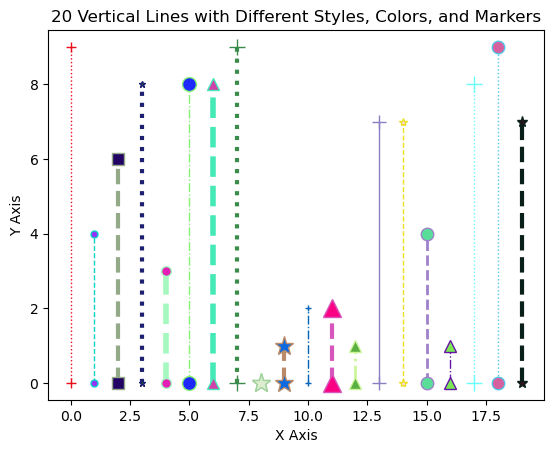

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(20)
y = np.random.randint(0, 10, size=20)

fig, ax = plt.subplots()

# draw 20 vertical lines with different styles and colors
for i in range(len(x)):
    line_style = np.random.choice(['-', '--', '-.', ':']) # random line style
    line_color = np.random.rand(3) # random RGB color
    line_width = np.random.randint(1, 5) # random line width
    marker = np.random.choice(['o', 's', '^', '*', '+']) # random marker
    marker_color = np.random.rand(3) # random RGB marker color
    marker_size = np.random.randint(5, 15) # random marker size
    ax.plot([x[i], x[i]], [0, y[i]], linestyle=line_style, color=line_color, linewidth=line_width, marker=marker, markerfacecolor=marker_color, markersize=marker_size)

ax.set_title('20 Vertical Lines with Different Styles, Colors, and Markers')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')

plt.show()


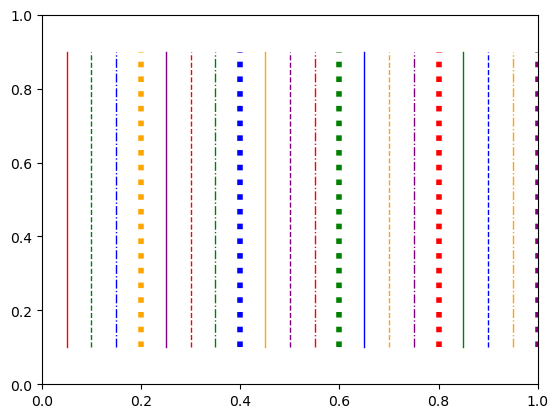

In [4]:
import matplotlib.pyplot as plt

# Define the number of lines
num_lines = 20

# Create the figure and axis
fig, ax = plt.subplots()

# Set the limits of the plot
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Define the different line styles and colors
line_styles = ['-', '--', '-.', ':']
line_colors = ['red', 'green', 'blue', 'orange', 'purple']

# Loop through the number of lines and create a vertical line with a random style and color
for i in range(num_lines):
    # Define the starting and ending points of the line
    x = 0.05 + i * 0.05
    y1 = 0.1
    y2 = 0.9
    
    # Define the line style and color
    line_style = line_styles[i % len(line_styles)]
    line_color = line_colors[i % len(line_colors)]
    line_width = 4 if line_style == ':' else 1
    
    # Add the line to the plot
    ax.plot([x, x], [y1, y2], linestyle=line_style, linewidth=line_width, color=line_color)

# Display the plot
plt.show()


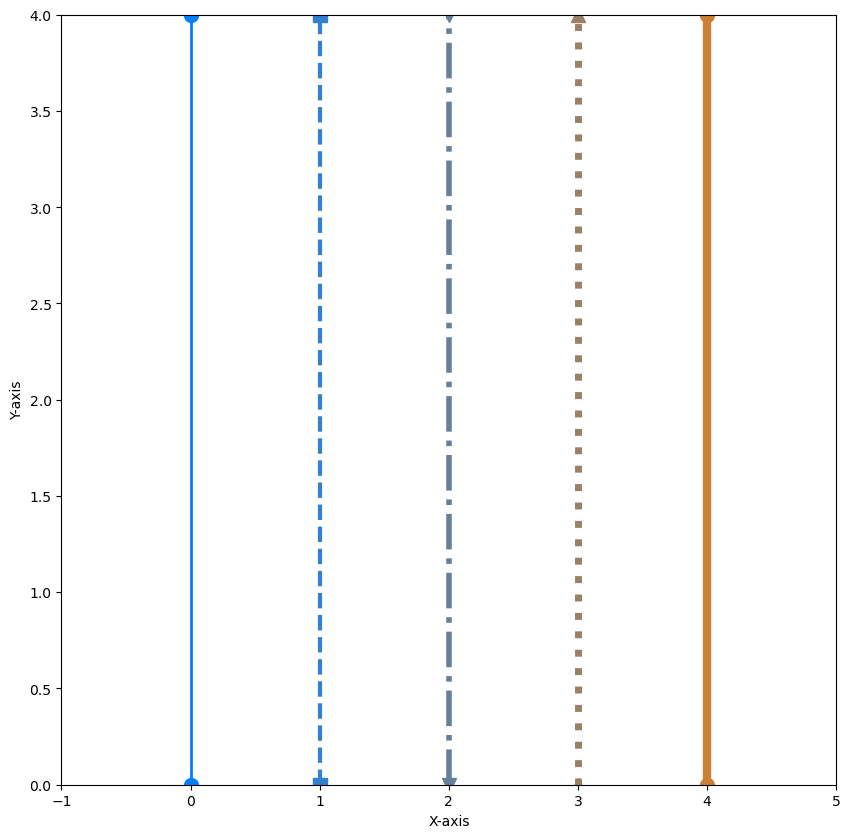

In [5]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))

# Create a list of y-coordinates for the lines
y_values = [0, 1, 2, 3, 4]

# Draw the lines with different styles and colors
for i in range(len(y_values)):
    # Set the color and line style for this line
    color = (i/len(y_values), 0.5, 1-i/len(y_values))
    line_style = ['-', '--', '-.', ':'][i % 4]
    marker_style = ['o', 's', 'v', '^'][i % 4]
    line_width = 2 + i/len(y_values) * 5
    
    # Draw the line
    ax.plot([i, i], [0, 4], linestyle=line_style, color=color, linewidth=line_width, marker=marker_style, markersize=10)

# Set the axis limits and labels
ax.set_xlim([-1, len(y_values)])
ax.set_ylim([0, 4])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.show()


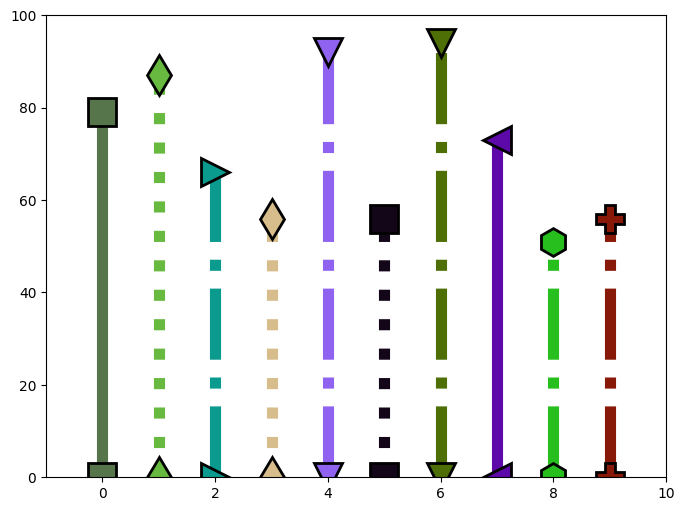

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.arange(10)
y = np.random.randint(1, 100, size=10)

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Loop through each line and add it to the plot
for i in range(10):
    # Set line color and style
    line_color = np.random.rand(3)
    line_style = np.random.choice(['-', '--', '-.', ':'])
    
    # Set marker style
    marker_style = np.random.choice(['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
    
    # Plot line
    ax.plot([i, i], [0, y[i]], color=line_color, linestyle=line_style, linewidth=8, marker=marker_style, markersize=20, markerfacecolor=line_color, markeredgewidth=2, markeredgecolor='black')
    
# Set x-axis and y-axis limits
ax.set_xlim([-1, 10])
ax.set_ylim([0, 100])

# Show plot
plt.show()


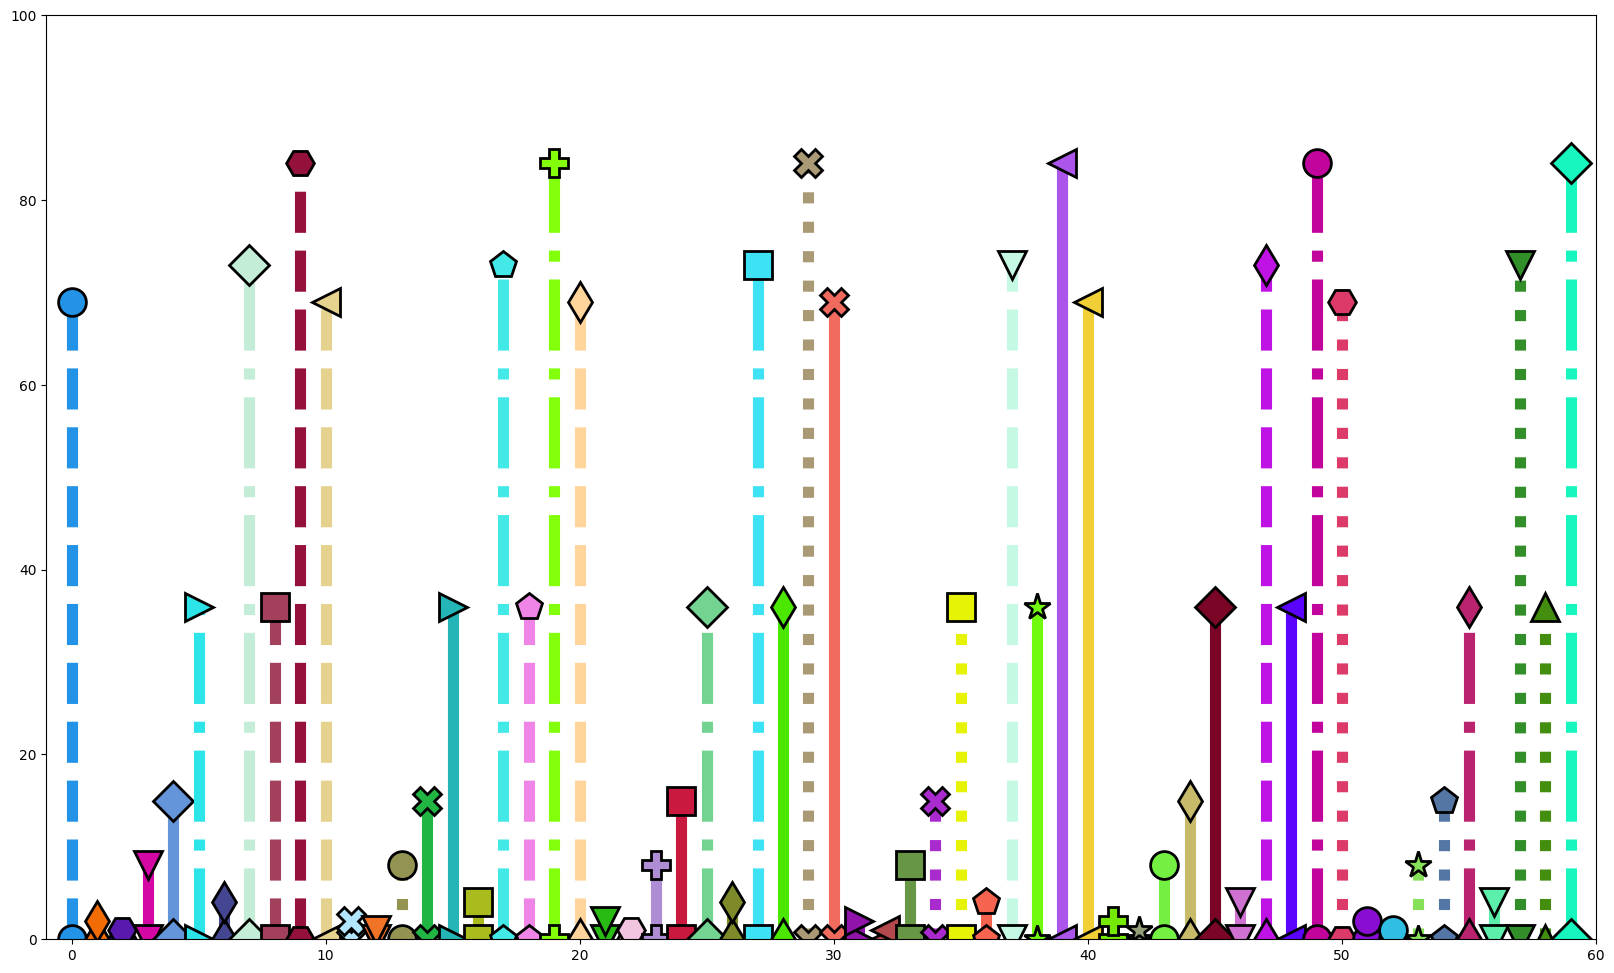

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.arange(10)
y = np.random.randint(1, 100, size=10)

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(20, 12))

# Loop through each line and add it to the plot
for i in range(60):
    # Set line color and style
    line_color = np.random.rand(3)
    line_style = np.random.choice(['-', '--', '-.', ':'])
    
    # Set marker style
    marker_style = np.random.choice(['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
    
    # Plot line
    j = i % 10
    ax.plot([i, i], [0, y[j]], color=line_color, linestyle=line_style, linewidth=8, marker=marker_style, markersize=20, markerfacecolor=line_color, markeredgewidth=2, markeredgecolor='black')
    
# Set x-axis and y-axis limits
ax.set_xlim([-1, 60])
ax.set_ylim([0, 100])

# Show plot
plt.show()


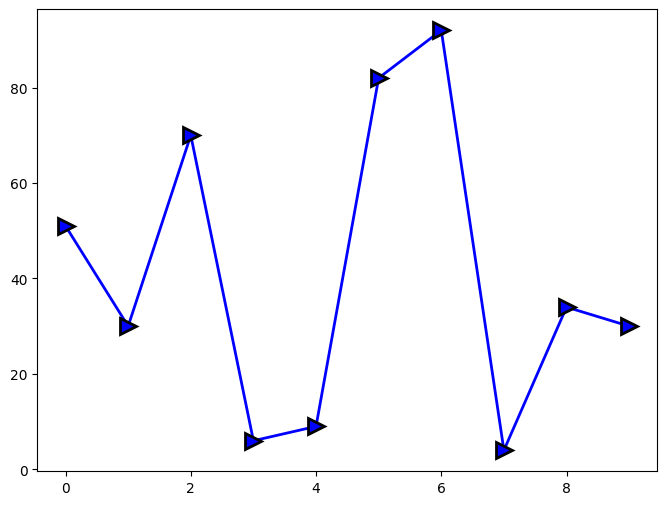

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.arange(10)
y = np.random.randint(1, 100, size=10)

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set marker style
marker_style = '>'

# Plot line
ax.plot(x, y, color='blue', linestyle='-', linewidth=2, marker=marker_style, markersize=12, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='black')

# Show plot
plt.show()


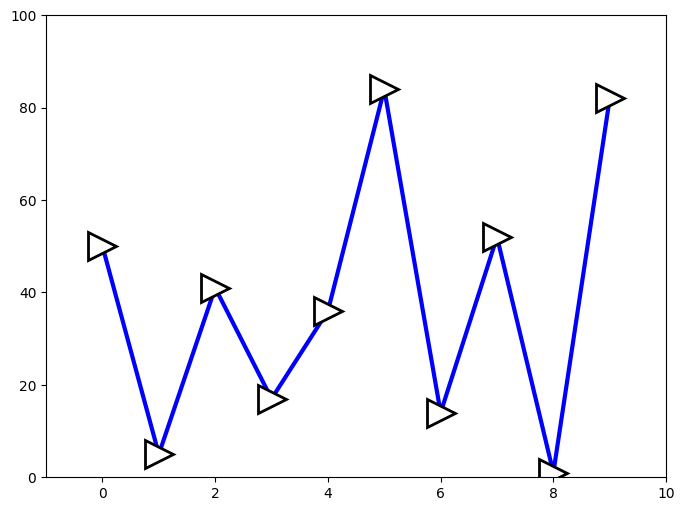

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.arange(10)
y = np.random.randint(1, 100, size=10)

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set marker style
marker_style = '>'

# Plot line with markers
ax.plot(x, y, color='blue', linestyle='-', linewidth=3, marker=marker_style, markersize=20, markerfacecolor='white', markeredgewidth=2, markeredgecolor='black')

# Set x-axis and y-axis limits
ax.set_xlim([-1, 10])
ax.set_ylim([0, 100])

# Show plot
plt.show()


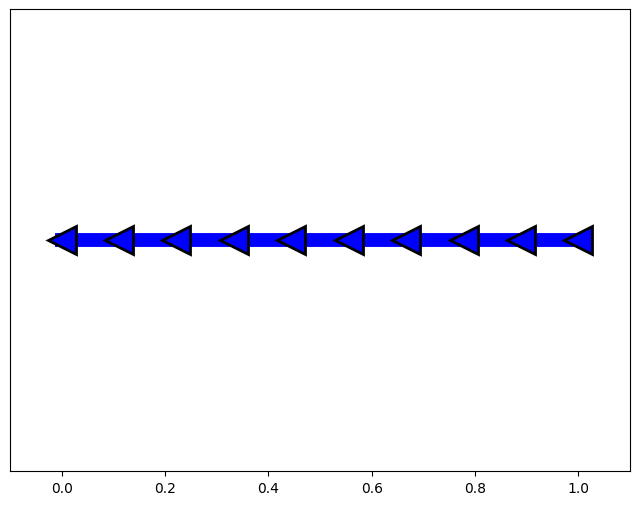

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
n_markers = 10
x = np.linspace(0, 1, n_markers)
y = np.ones(n_markers) * 0.5

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot line with markers
ax.plot(x, y, color='blue', linestyle='-', linewidth=10, marker=np.random.choice(['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']), markersize=20, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='black')

# Set x-axis and y-axis limits
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])

# Hide ticks and labels for y-axis
ax.yaxis.set_visible(False)

# Show plot
plt.show()


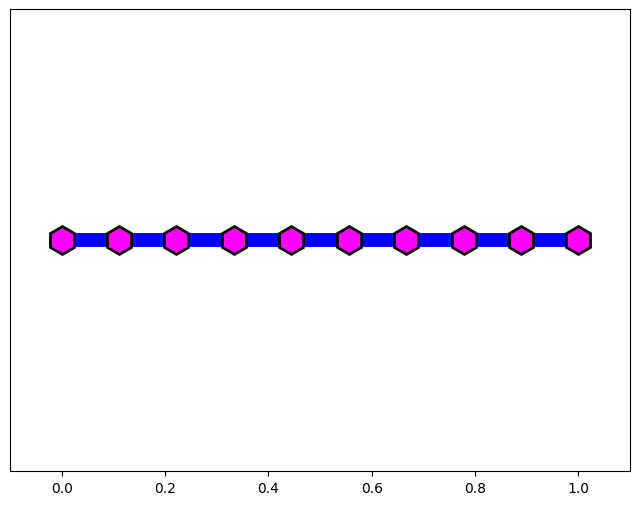

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
n_markers = 10
x = np.linspace(0, 1, n_markers)
y = np.ones(n_markers) * 0.5

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set marker colors randomly
marker_colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan', 'magenta', 'black']


# Plot line with markers
ax.plot(x, y, color='blue', linestyle='-', linewidth=10, marker=np.random.choice(['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']), markersize=20, markerfacecolor=marker_colors[np.random.choice(len(marker_colors))], markeredgewidth=2, markeredgecolor='black')

# Set x-axis and y-axis limits
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])

# Hide ticks and labels for y-axis
ax.yaxis.set_visible(False)

# Show plot
plt.show()


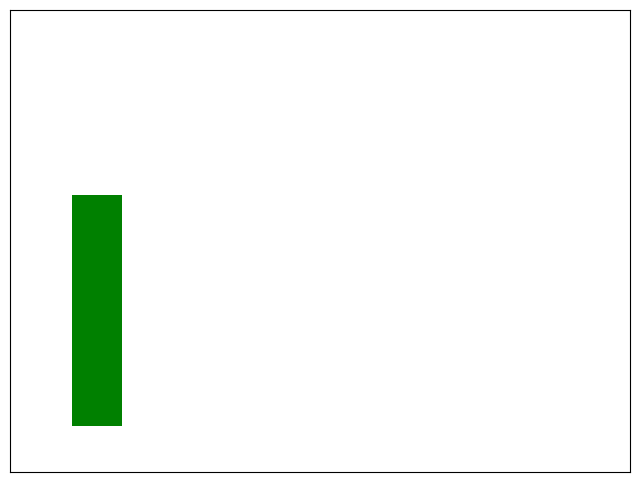

In [81]:
import matplotlib.pyplot as plt

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set health bar parameters
health = 0.8  # health percentage
bar_width = 10  # width of the health bar in pixels
bar_height = 50  # height of the health bar in pixels
bar_bottom_left = [10, 10]  # bottom-left coordinates of the health bar

# Calculate bar width and height based on health percentage
bar_width = int(bar_width * health)
bar_height = int(bar_height)

# Create rectangle patch for the health bar
rect = plt.Rectangle(bar_bottom_left, bar_width, bar_height, facecolor='green')

# Add the rectangle patch to the plot
ax.add_patch(rect)

# Set x-axis and y-axis limits
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

# Hide ticks and labels for x-axis and y-axis
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Show plot
plt.show()


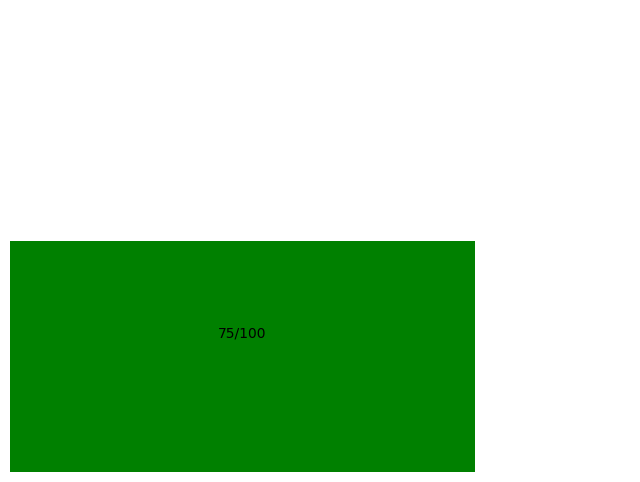

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set the health value
health = 75

# Plot the health bar
ax.bar(x=0, height=10, width=health, color='green', align='edge')

# Set x-axis and y-axis limits
ax.set_xlim([0, 100])
ax.set_ylim([0, 20])

# Hide ticks and labels for both axes
ax.axis('off')

# Set the health value as text
ax.text(health/2, 6, f'{health}/100', ha='center', va='center')

# Show plot
plt.show()


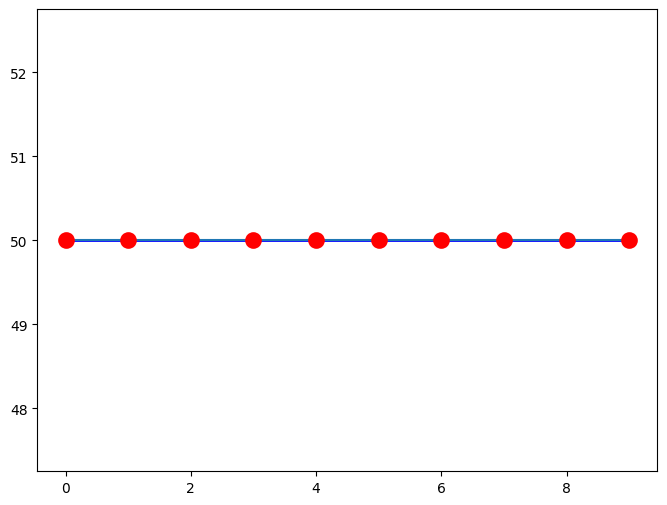

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.arange(10)
y = np.random.randint(1, 100, size=10)

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Set line color and style
line_color = 'blue'
line_style = '-'

# Set marker style and color
marker_style = 'o'
marker_color = 'red'

# Plot line with markers
ax.plot(x, np.ones_like(x)*50, color=line_color, linestyle=line_style, linewidth=2)
ax.plot(x, np.ones_like(x)*50, marker=marker_style, markersize=10, markerfacecolor=marker_color, markeredgewidth=2, markeredgecolor=marker_color)

# Show plot
plt.show()


([], [])

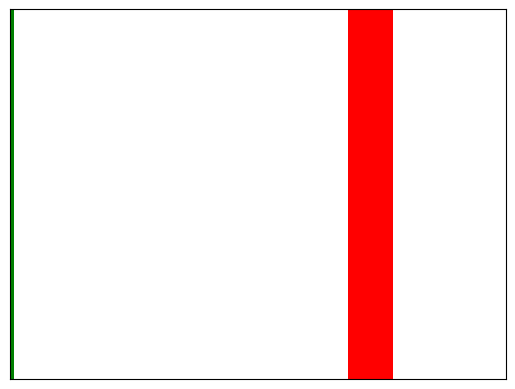

In [85]:
import matplotlib.pyplot as plt

# Set the maximum health and current health
max_health = 100
current_health = 75

# Define the bar properties
bar_width = 10
bar_height = 1
x_pos = 0
y_pos = 0

# Calculate the remaining health percentage
remaining_health_pct = 1 - current_health / max_health

# Create a bar plot for the current health
plt.bar(x_pos, current_health, color='green', align='edge')

# Create a bar plot for the remaining health
plt.bar(x_pos + current_health, max_health - current_health, width=bar_width, color='red', align='edge')

# Set the x-axis and y-axis limits
plt.xlim([x_pos, max_health + bar_width])
plt.ylim([y_pos, y_pos + bar_height])

# Hide the x-axis and y-axis ticks
plt.xticks([])
plt.yticks([])

# Show the red color for the remaining health below 75%


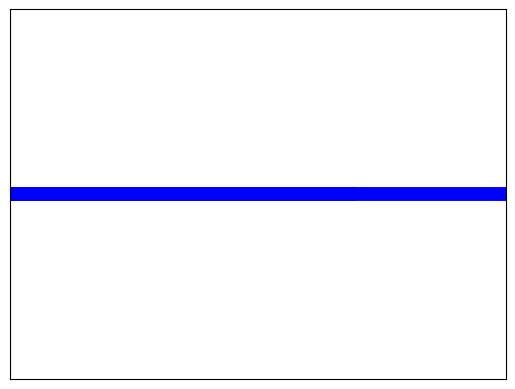

In [87]:
import matplotlib.pyplot as plt

# Set max and current health
max_health = 100
current_health = 70

# Set colors for health bar
health_bar_color = 'blue'
low_health_color = 'red'

# Calculate percentage of current health
health_percent = current_health / max_health

# Create figure and axes
fig, ax = plt.subplots()

# Plot full health bar
ax.plot([0, 1], [0, 0], color=health_bar_color, linewidth=10, solid_capstyle='butt')

# Plot current health bar
ax.plot([0, health_percent], [0, 0], color=health_bar_color, linewidth=10, solid_capstyle='butt')

# Plot low health indicator if necessary
if health_percent < 0.25:
    ax.plot([health_percent, 1], [0, 0], color=low_health_color, linewidth=10, solid_capstyle='butt')

# Set axis limits and remove ticks and labels
ax.set_xlim([0, 1])
ax.set_ylim([-0.05, 0.05])
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()


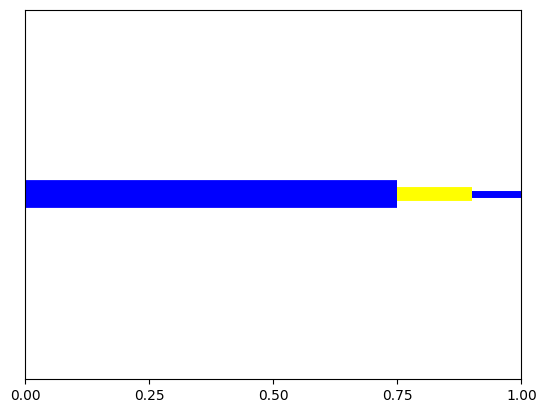

In [97]:
import matplotlib.pyplot as plt

# Set max and current health
max_health = 100
current_health = 75

# Set colors for health bar
health_bar_color = 'blue'
low_health_color = 'red'

# Calculate percentage of current health
health_percent = current_health / max_health

# Create figure and axes
fig, ax = plt.subplots()

# Plot full health bar
ax.plot([0, 1], [0, 0], color=health_bar_color, linewidth=5, solid_capstyle='butt')

# Plot current health bar
if health_percent < 0.75:
    # ax.plot([0, health_percent], [0, 0], color=health_bar_color, linewidth=10, solid_capstyle='butt')
    ax.plot([health_percent, 1], [0, 0], color=low_health_color, linewidth=10, solid_capstyle='butt')
else:
    ax.plot([0, health_percent], [0, 0], color=health_bar_color, linewidth=20, solid_capstyle='butt')
ax.plot([health_percent, 0.90], [0, 0], color='yellow', linewidth=10, solid_capstyle='butt')
# Set axis limits and remove ticks and labels
ax.set_xlim([0, 1])
ax.set_ylim([-0.05, 0.05])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticks([])

# Show plot
plt.show()


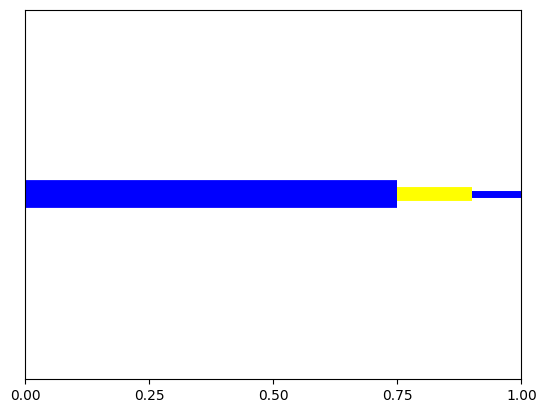

In [104]:
import matplotlib.pyplot as plt

# Set max and current health
max_health = 100
current_health = 75

# Set colors for health bar
health_bar_color = 'blue'
low_health_color = 'red'

# Calculate percentage of current health
health_percent = current_health / max_health

# Create figure and axes
fig, ax = plt.subplots()

# Plot full health bar
ax.plot([0, 1], [0, 0], color=health_bar_color, linewidth=5, solid_capstyle='butt')

# Plot current health bar
if health_percent < 0.75:
    # ax.plot([0, health_percent], [0, 0], color=health_bar_color, linewidth=10, solid_capstyle='butt')
    ax.plot([health_percent, 1], [0, 0], color=low_health_color, linewidth=10, solid_capstyle='butt')
else:
    ax.plot([0, health_percent], [0, 0], color=health_bar_color, linewidth=20, solid_capstyle='butt')
ax.plot([health_percent, 0.90], [0, 0], color='yellow', linewidth=10, solid_capstyle='butt')
# Set axis limits and remove ticks and labels


x = np.arange(10)
y = np.random.randint(1, 100, size=10)

# Set figure size and create subplots
# fig, ax = plt.subplots(figsize=(8, 6))

# Set line color and style
line_color = 'blue'
line_style = '-'

# Set marker style and color
marker_style = 'o'
marker_color = 'red'

# Plot line with markers
ax.plot(x, np.ones_like(x)*50, color=line_color, linestyle=line_style, linewidth=2)
ax.plot(x, np.ones_like(x)*50, marker=marker_style, markersize=10, markerfacecolor=marker_color, markeredgewidth=20, markeredgecolor=marker_color)



ax.set_xlim([0, 1])
ax.set_ylim([-0.05, 0.05])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticks([])

# Show plot
plt.show()

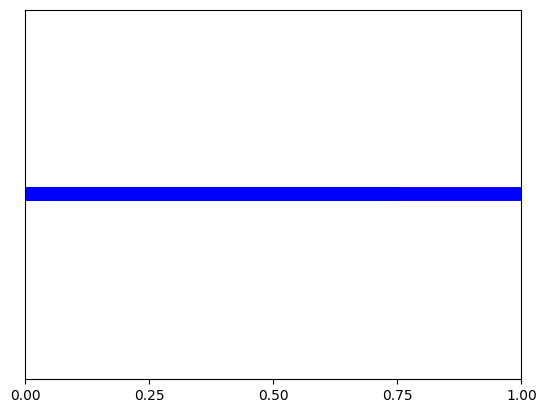

In [101]:
import matplotlib.pyplot as plt

# Set max and current health
max_health = 100
current_health = 75

# Set colors for health bar
health_bar_color = 'blue'
low_health_color = 'red'

# Calculate percentage of current health
health_percent = current_health / max_health

# Create figure and axes
fig, ax = plt.subplots()

# Plot full health bar
ax.plot([0, 1], [0, 0], color=health_bar_color, linewidth=10, solid_capstyle='butt')

# Plot current health bar
if health_percent < 0.75:
    ax.plot([0, health_percent], [0, 0], color=health_bar_color, linewidth=10, solid_capstyle='butt')
    ax.plot([health_percent, 1], [0, 0], color=low_health_color, linewidth=10, solid_capstyle='butt')
else:
    ax.plot([0, health_percent], [0, 0], color=health_bar_color, linewidth=10, solid_capstyle='butt')

# Set axis limits and remove ticks and labels
ax.set_xlim([0, 1])
ax.set_ylim([-0.05, 0.05])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticks([])

# Show plot
plt.show()


Text(0, 0.5, 'Y')

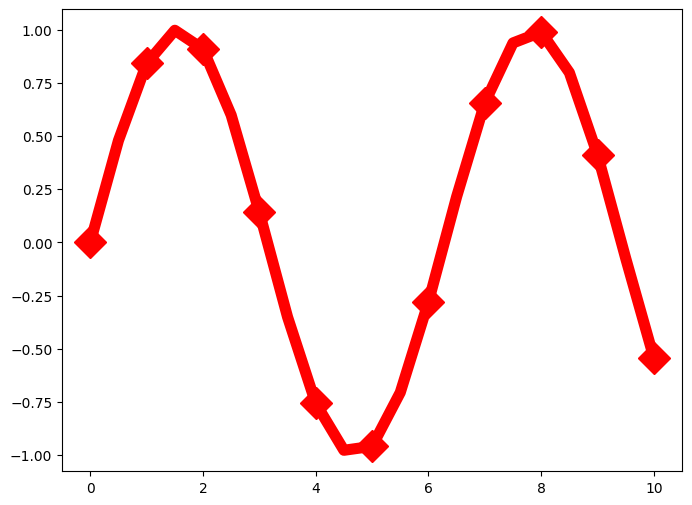

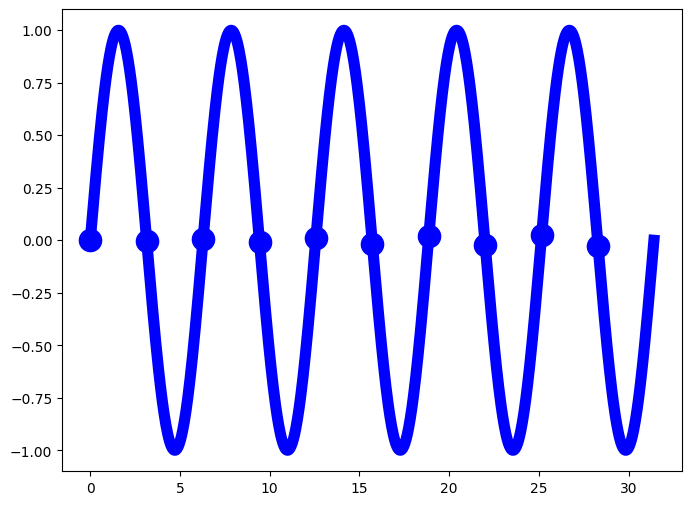

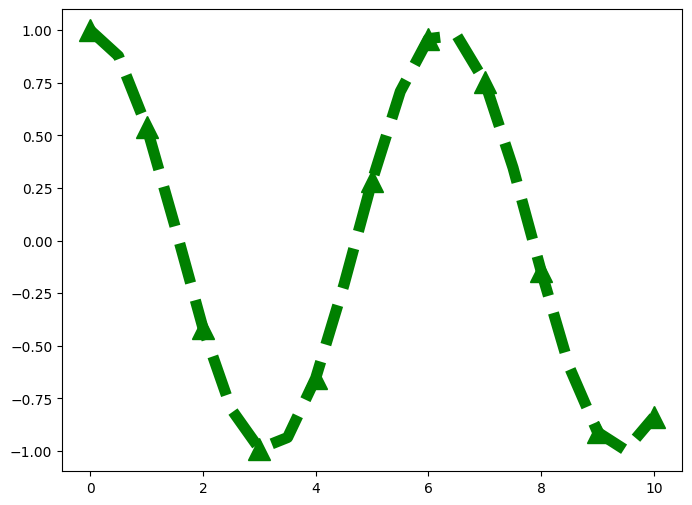

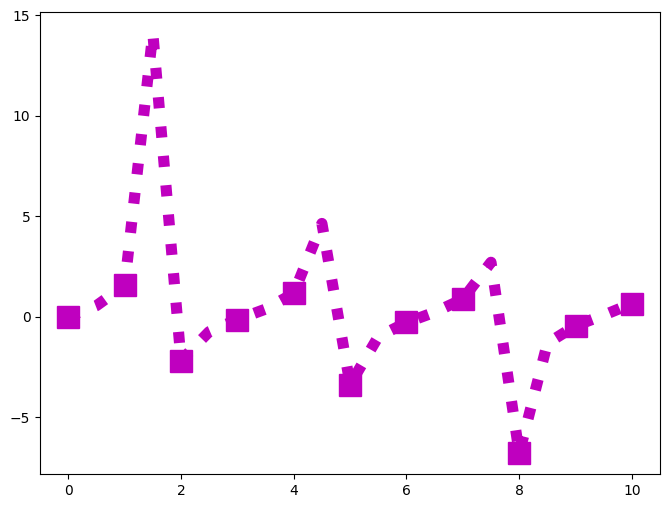

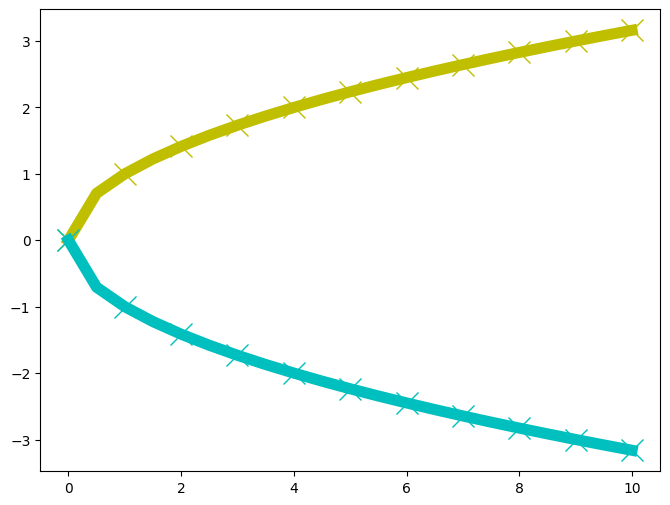

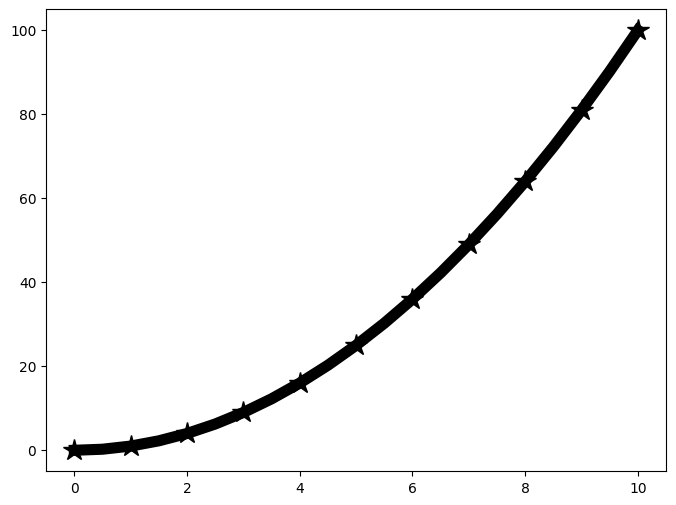

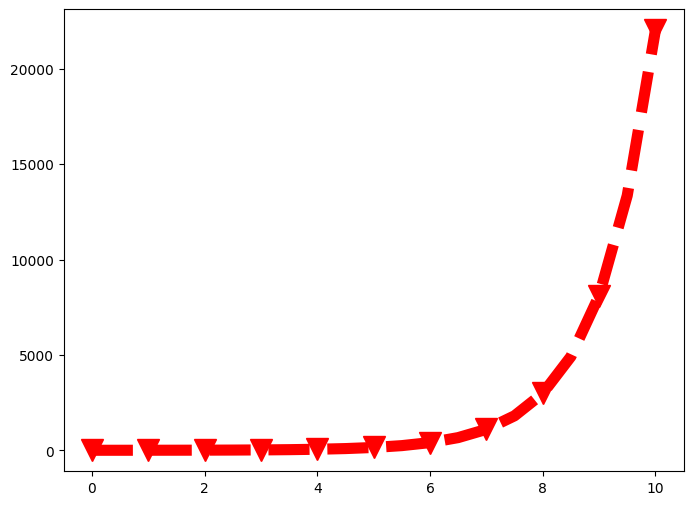

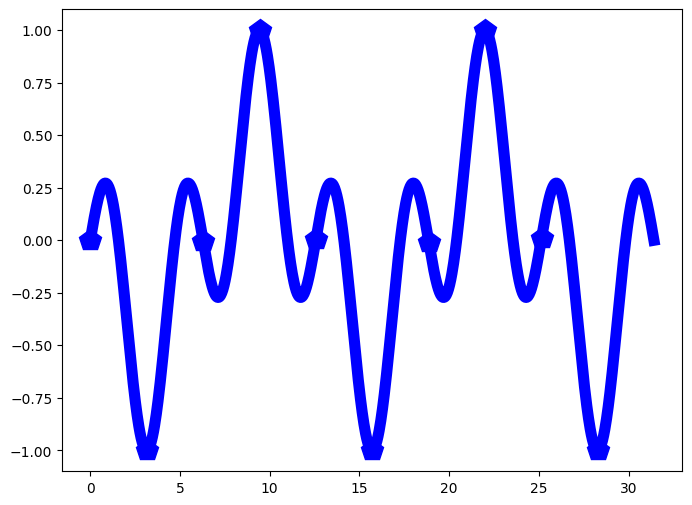

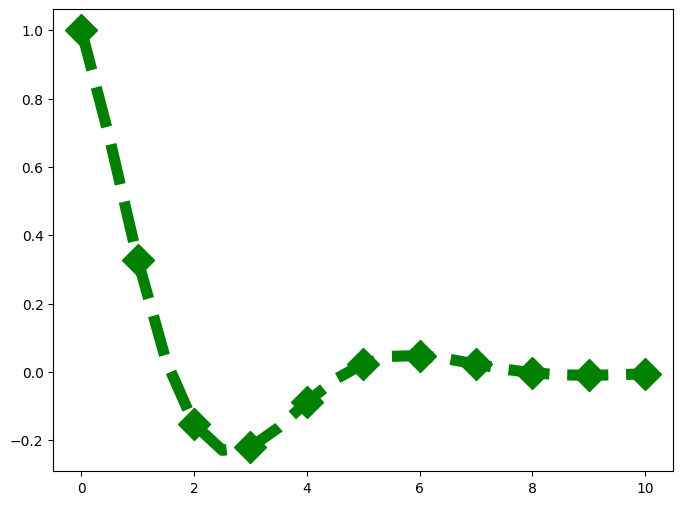

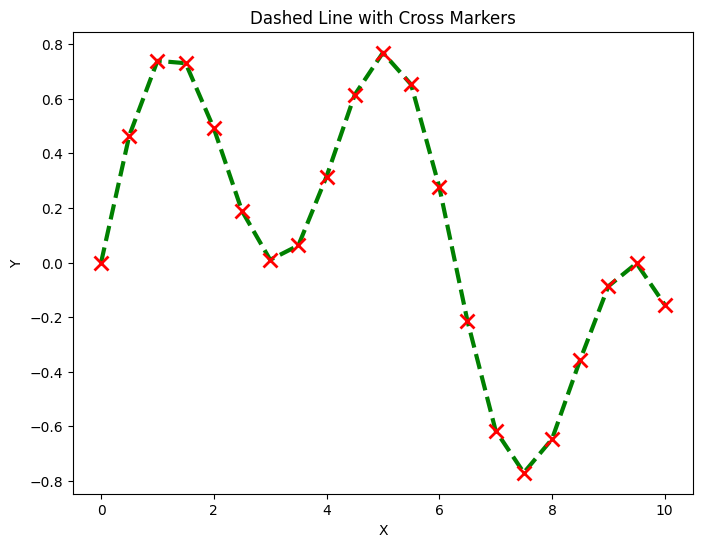

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Line 1: Zigzag with diamond markers
x = np.linspace(0, 10, 21)
y = np.sin(x)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, 'r-', linewidth=8, marker='D', markersize=16, markevery=2)

# Line 2: Spiral with circle markers
x = np.linspace(0, 10*np.pi, 1000)
y = np.sin(x)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, 'b-', linewidth=8, marker='o', markersize=16, markevery=100)

# Line 3: Dashed with triangle markers
x = np.linspace(0, 10, 21)
y = np.cos(x)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, 'g--', linewidth=8, marker='^', markersize=16, markevery=2)

# Line 4: Dotted with square markers
x = np.linspace(0, 10, 21)
y = np.tan(x)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, 'm:', linewidth=8, marker='s', markersize=16, markevery=2)

# Line 5: Dual-color with cross markers
x = np.linspace(0, 10, 21)
y = np.sqrt(x)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, 'y-', linewidth=8, marker='x', markersize=16, markevery=2)
ax.plot(x, -y, 'c-', linewidth=8, marker='x', markersize=16, markevery=2)

# Line 6: Gradient with star markers
x = np.linspace(0, 10, 21)
y = x**2
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-k', linewidth=8, marker='*', markersize=16, markevery=2)

# Line 7: Dashed with inverted triangle markers
x = np.linspace(0, 10, 21)
y = np.exp(x)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '--r', linewidth=8, marker='v', markersize=16, markevery=2)

# Line 8: Wave with pentagon markers
x = np.linspace(0, 10*np.pi, 1000)
y = np.cos(x) * np.sin(x/2)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-b', linewidth=8, marker='p', markersize=16, markevery=100)

# Line 9: Double-dashed with diamond markers
x = np.linspace(0, 10, 21)
y = np.cos(x) * np.exp(-x/2)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '--g', linewidth=8, marker='D', markersize=16, markevery=2)

# Line 10: Dashed with cross markers
x = np.linspace(0, 10, 21)
y = np.sin(x) * np.cos(x/2)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, linestyle='--', linewidth=3, color='green', marker='x', markersize=10, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='red')
ax.set_title('Dashed Line with Cross Markers')
ax.set_xlabel('X')
ax.set_ylabel('Y')



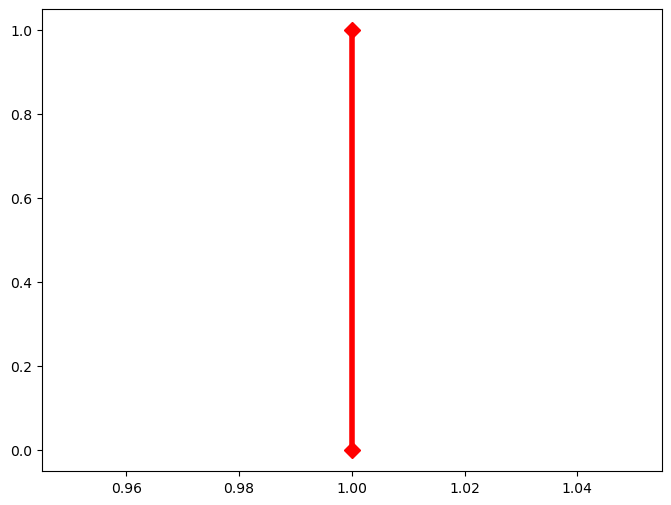

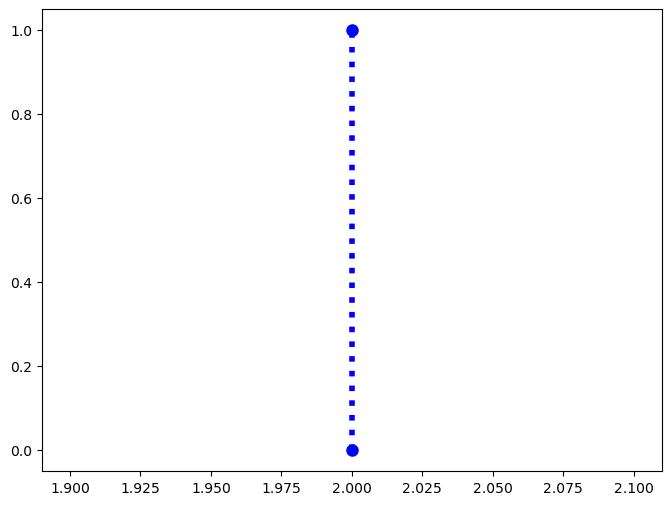

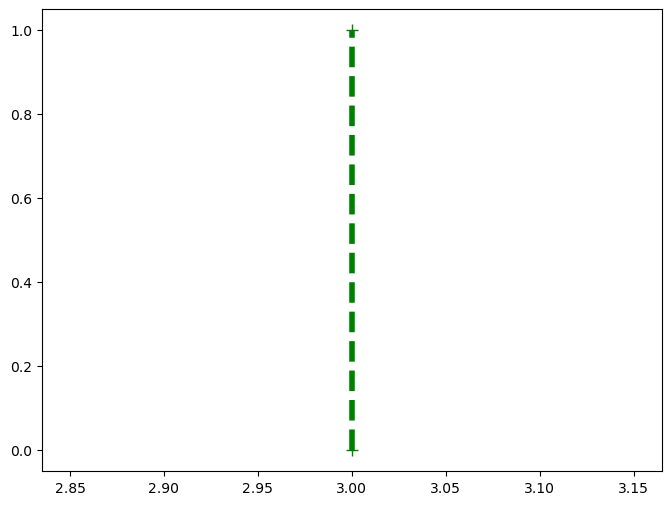

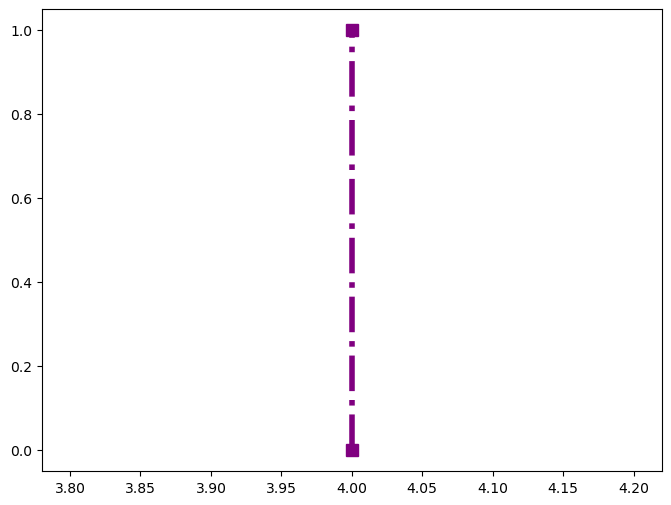

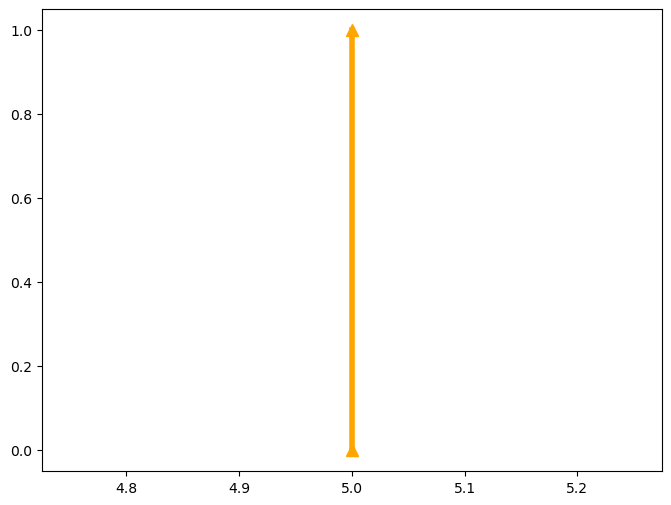

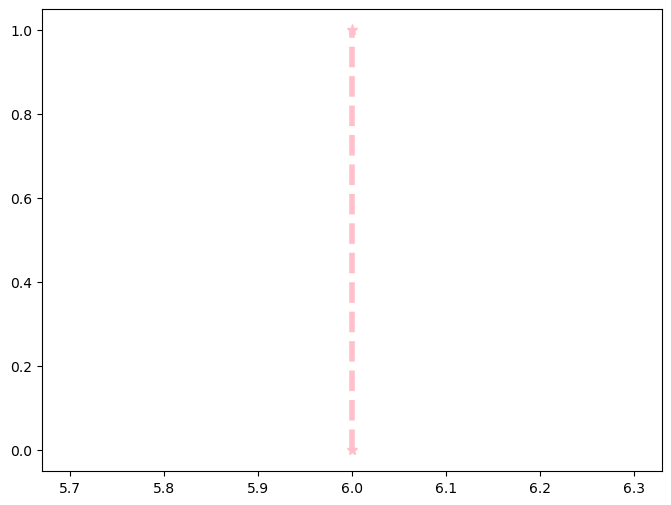

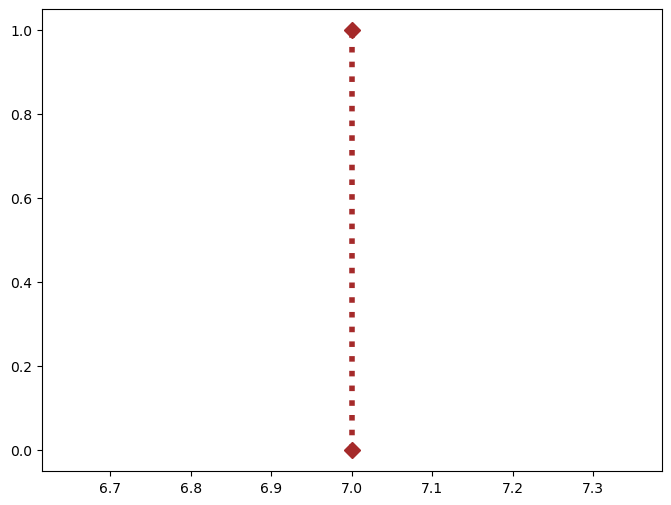

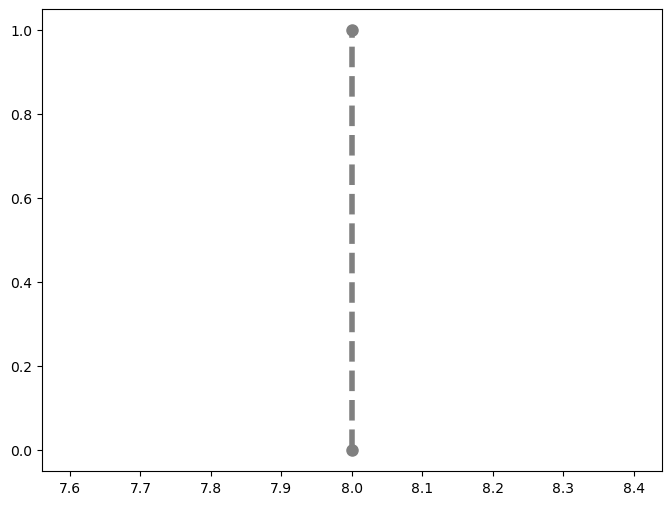

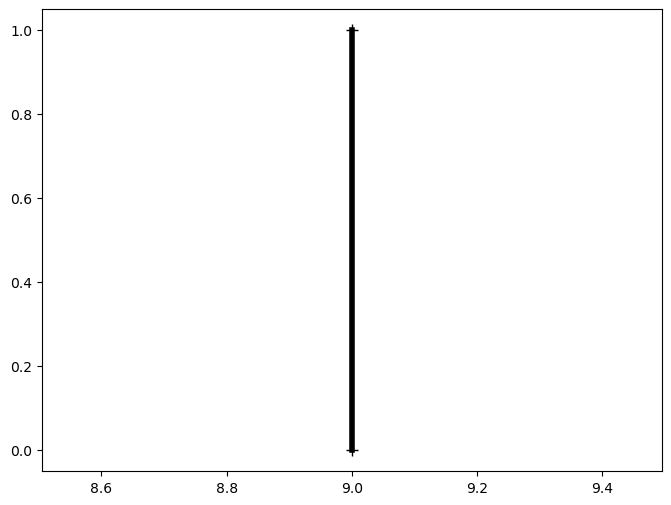

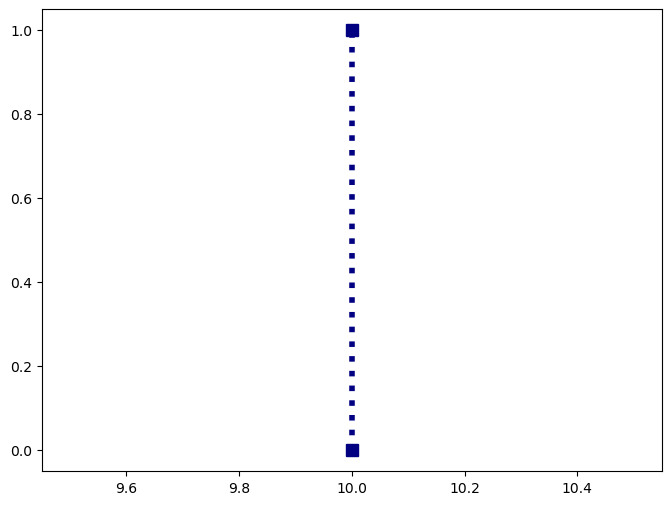

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Vertical line with diamond markers
x = np.array([1, 1])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-D', markersize=8, linewidth=4, color='red')

# Vertical line with circle markers and dotted style
x = np.array([2, 2])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, ':o', markersize=8, linewidth=4, color='blue')

# Vertical line with plus markers and dashed style
x = np.array([3, 3])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '--+', markersize=8, linewidth=4, color='green')

# Vertical line with square markers and dash-dot style
x = np.array([4, 4])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-.s', markersize=8, linewidth=4, color='purple')

# Vertical line with triangle markers and solid style
x = np.array([5, 5])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-^', markersize=8, linewidth=4, color='orange')

# Vertical line with asterisk markers and dashed style
x = np.array([6, 6])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '--*', markersize=8, linewidth=4, color='pink')

# Vertical line with diamond markers and dotted style
x = np.array([7, 7])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, ':D', markersize=8, linewidth=4, color='brown')

# Vertical line with circle markers and dashed style
x = np.array([8, 8])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '--o', markersize=8, linewidth=4, color='gray')

# Vertical line with plus markers and solid style
x = np.array([9, 9])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-+', markersize=8, linewidth=4, color='black')

# Vertical line with square markers and dotted style
x = np.array([10, 10])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, ':s', markersize=8, linewidth=4, color='navy')

plt.show()


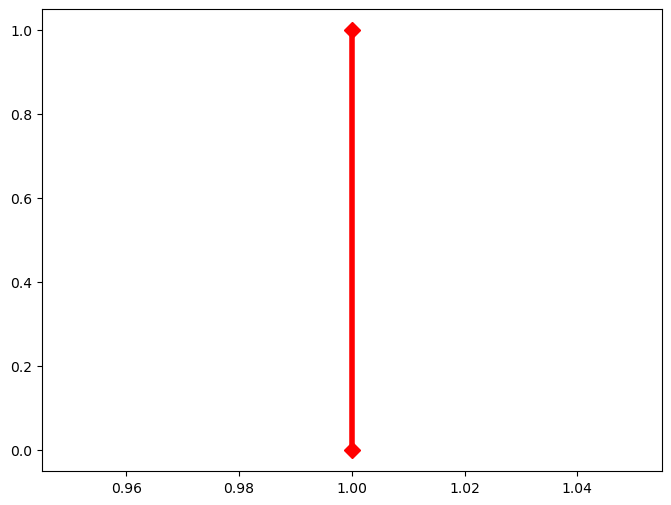

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Vertical line with diamond markers
x = np.array([1, 1])
y = np.array([0, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-D', markersize=8, linewidth=4, color='red')
plt.show()

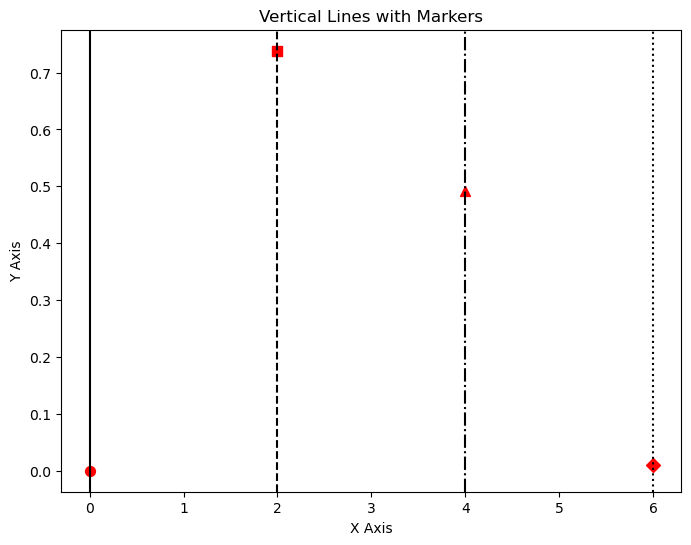

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.linspace(0, 10, 21)
y = np.sin(x) * np.cos(x/2)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# Define styles and markers
styles = ["solid", "dashed", "dashdot", "dotted"]
markers = ["o", "s", "^", "D", "*", "p", "v", "h", "+", "x"]

# Plot vertical lines with markers
for i in range(len(styles)):
    ax.axvline(x=i*2, linestyle=styles[i], color='k')
    ax.scatter(i*2, y[i*2], marker=markers[i], s=50, color='r')
    
# Set plot title and labels
ax.set_title("Vertical Lines with Markers")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")

# Show plot
plt.show()


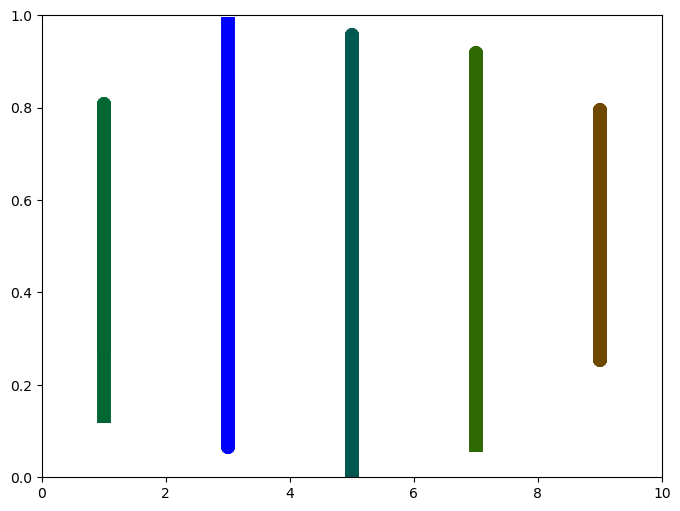

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

# create a colormap with a linear gradient of colors
cmap = LinearSegmentedColormap.from_list('mycmap', ['red', 'green', 'blue'])

# define the x values where the lines will be drawn
x_values = [1, 3, 5, 7, 9]

# define the markers to use for each line
markers = ['o', 's', '^', 'v', '*']

# create a list to hold the lines
lines = []

# create a line for each x value and marker combination
for x, marker in zip(x_values, markers):
    # define the y values for the line
    y_values = np.random.rand(10)
    # create a list of (x,y) tuples for the line
    points = list(zip([x]*len(y_values), y_values))
    # create a LineCollection from the points
    line = LineCollection([points], colors=[cmap(y) for y in y_values], linewidths=10)
    # set the marker for the line
    # line.set_marker(marker)
    # add the line to the list
    lines.append(line)

# create the plot and add the lines to it
fig, ax = plt.subplots(figsize=(8,6))
for line in lines:
    ax.add_collection(line)

# set the x and y limits of the plot
ax.set_xlim([0, 10])
ax.set_ylim([0, 1])

# show the plot
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Generate data
x = np.linspace(0, 10, 21)
y = np.sin(x) * np.cos(x/2)
segments = np.stack((x, y), axis=-1)
colors = np.random.rand(len(x) - 1)

# Create LineCollection object
lc = LineCollection([segments], colors=colors, linewidth=10)

# Get the line segments as an array
segments_array = lc.get_segments()

# Modify the colors of each line segment
for i in range(len(segments_array)):
    segment = segments_array[i]
    color = colors[i]
    lc.set_color([i], [color])

# Plot the LineCollection object
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
plt.show()


ValueError: Invalid RGBA argument: 0.26050693128784097

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Generate data
x = np.linspace(0, 10, 21)
y = np.sin(x) * np.cos(x/2)
segments = np.stack((x, y), axis=-1)
colors = np.random.uniform(0, 1, size=len(x) - 1)

# Create LineCollection object
lc = LineCollection([segments], colors=colors, linewidth=10)

# Get the line segments as an array
segments_array = lc.get_segments()

# Modify the colors of each line segment
for i in range(len(segments_array)):
    segment = segments_array[i]
    color = colors[i]
    lc.set_color([i], [color])

# Plot the LineCollection object
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
plt.show()


ValueError: Invalid RGBA argument: 0.7660705536286083


(eog:1540663): Handy-WARNING **: 22:06:23.907: Using GtkSettings:gtk-application-prefer-dark-theme together with HdyStyleManager is unsupported. Please use HdyStyleManager:color-scheme instead.


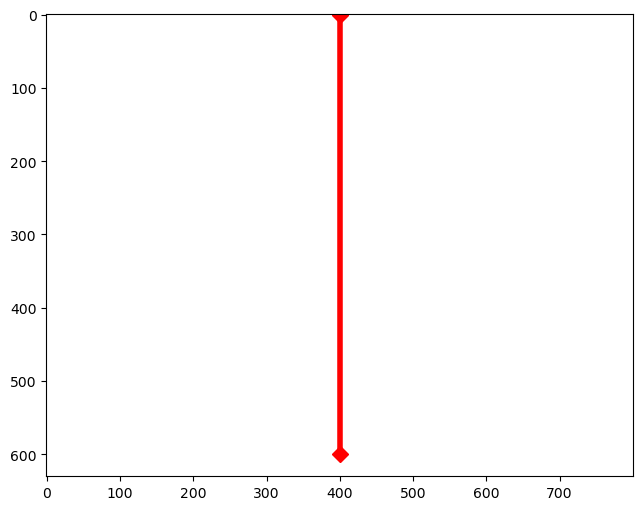

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Create new PIL image with white background
width, height = 800, 600
image = Image.new('RGB', (width, height), (255, 255, 255))

# Convert PIL image to matplotlib-compatible format
fig, ax = plt.subplots(figsize=(width/100, height/100))
ax.imshow(np.asarray(image))

# Vertical line with diamond markers
x = np.array([400, 400])
y = np.array([0, 600])
ax.plot(x, y, '-D', markersize=8, linewidth=4, color='red')

# Convert matplotlib figure back to PIL image
fig.canvas.draw()
pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# Show PIL image
pil_image.show()


ValueError: could not broadcast input array from shape (600,800,3) into shape (400,600,3)

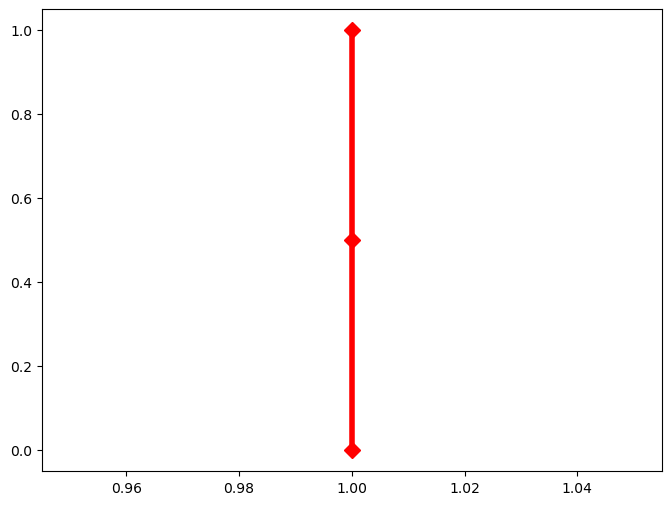

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Create a white PIL image
img = Image.new('RGB', (800, 600), color='white')

# Convert the PIL image to a numpy array
arr = np.array(img)

# Vertical line with diamond markers in the middle
x = np.array([1, 1, 1])
y = np.array([0, 0.5, 1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, '-D', markersize=8, linewidth=4, color='red')

# Convert the plot to a PIL Image and paste it onto the original PIL image
canvas = plt.get_current_fig_manager().canvas
canvas.draw()
plot_img = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
arr2 = np.array(plot_img)
arr[100:500, 100:700] = arr2
result_img = Image.fromarray(arr)

# Show the resulting image
result_img.show()


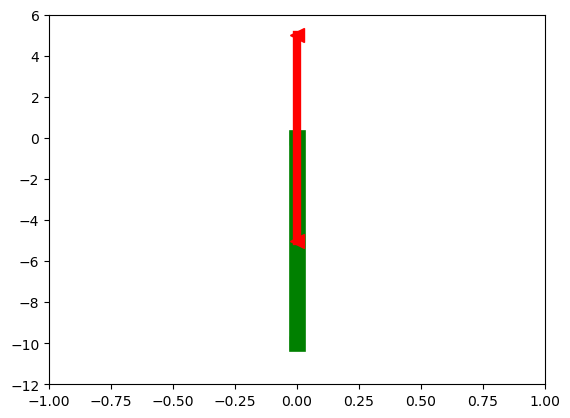

In [26]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots()

# Plot the initial line going downwards
ax.plot([0, 0], [0, -10], color='green', linewidth=12, marker=">", markersize=10)

# Plot the line going upwards after reversal
ax.plot([0, 0], [-5, 5], color='red', linewidth=6, marker="<", markersize=10)

# Set the axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-12, 6])

# Show the plot
plt.show()


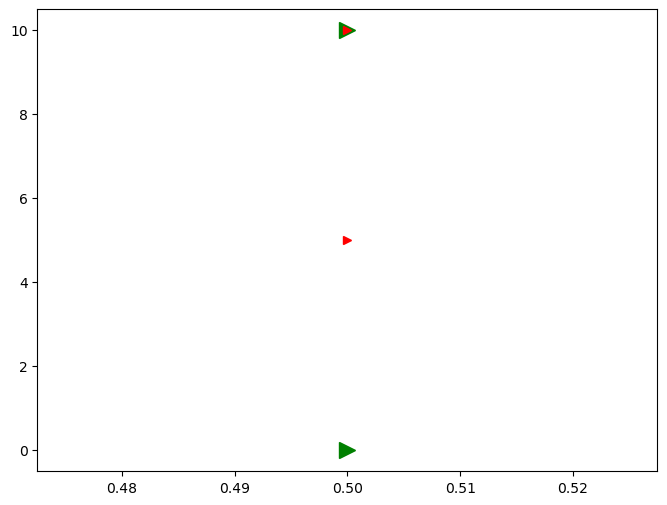

In [27]:
import matplotlib.pyplot as plt

# Vertical line with arrow marker
x1 = [0.5, 0.5]
y1 = [0, 10]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y1, '>', markersize=12, linewidth=10, color='green')

# Red line inside green line
x2 = [0.5, 0.5]
y2 = [5, 10]
ax.plot(x2, y2, '>', markersize=6, linewidth=6, color='red')

plt.show()


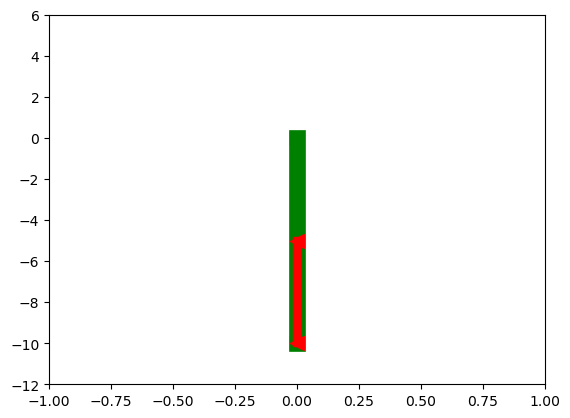

In [30]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots()

# Plot the initial line going downwards
ax.plot([0, 0], [0, -10], color='green', linewidth=12, marker=">", markersize=10)

# Plot the line going upwards after reversal
ax.plot([0, 0], [-10, -5], color='red', linewidth=6, marker="<", markersize=10)

# Set the axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-12, 6])

# Show the plot
plt.show()


In [ ]:
Line styles:

- : Solid line
-- : Dashed line
-. : Dash-dot line
: : Dotted line
Markers:

. : Point marker
o : Circle marker
v : Downward triangle marker
^ : Upward triangle marker
< : Leftward triangle marker
> : Rightward triangle marker
s : Square marker
p : Pentagon marker
* : Star marker
+ : Plus marker
x : Cross (times) marker
D : Diamond marker
d : Small diamond marker
h : Hexagon1 marker
H : Hexagon2 marker
You can combine line styles and markers in various ways, for example --o, -.s, :*

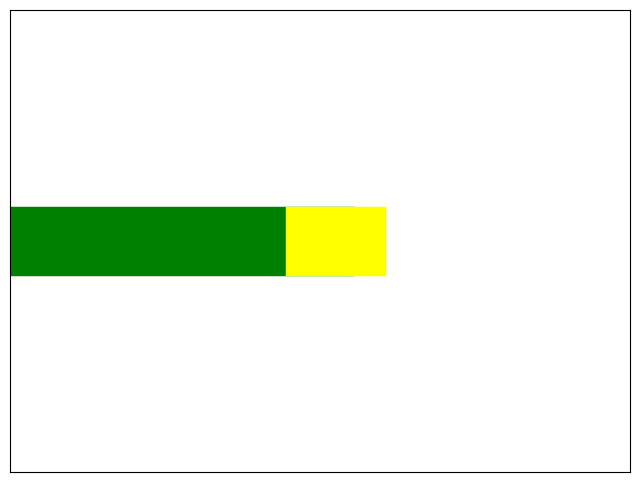

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize health values
health = 1000
profit = 100

# Calculate health values
new_health = health + profit
health_diff = new_health - 1000
if health_diff >= 0:
    green_health = 1000
    yellow_health = health_diff
    red_health = 0
else:
    green_health = new_health
    yellow_health = 0
    red_health = abs(health_diff)

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot green health
ax.plot([0, green_health], [0, 0], color='green', linewidth=50)

# Plot yellow health
if yellow_health > 0:
    ax.plot([green_health, new_health], [0, 0], color='yellow', linewidth=50)

# Plot red health
if red_health > 0:
    ax.plot([new_health, 2000], [0, 0], color='red', linewidth=50)

# Set x-axis and y-axis limits
ax.set_xlim([0, 2000])
ax.set_ylim([-1, 1])

# Hide ticks and labels
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()


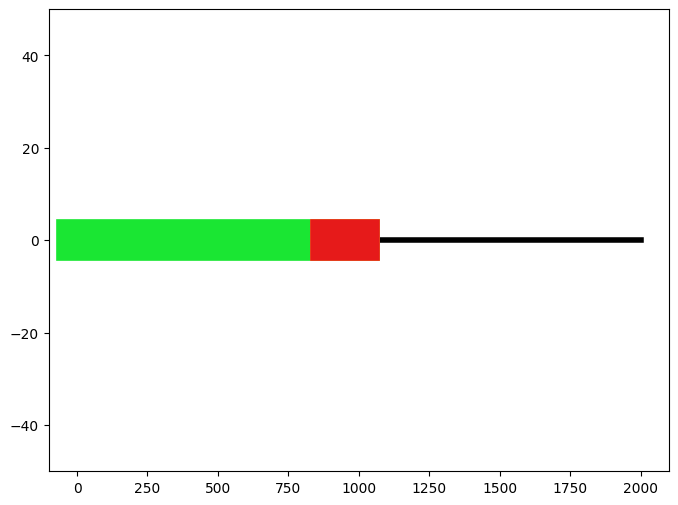

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize health and profit values
health = 1000
profit = -100

# Define colors
GREEN = np.array([0.1, 0.9, 0.2])
YELLOW = np.array([1, 1, 0.2])
RED = np.array([0.9, 0.1, 0.1])

# Calculate health bar values
bar_green = health - max(profit, 0)
bar_yellow = min(profit, 0) if profit < 0 else 0
bar_red = -profit if profit < 0 else 0

# Set figure size and create subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot health bar
ax.plot([0, 2000], [0, 0], color='black', linewidth=4)
ax.plot([0, bar_green], [0, 0], color=GREEN, linewidth=30)
ax.plot([bar_green, bar_green+bar_yellow], [0, 0], color=YELLOW, linewidth=30)
ax.plot([bar_green+bar_yellow, health], [0, 0], color=RED, linewidth=30)

# Set x-axis and y-axis limits
ax.set_xlim([-100, 2100])
ax.set_ylim([-50, 50])

# Show plot
plt.show()


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_health_bar(profit=0):
    # Define the colors for the bars
    green_color = (0, 1, 0, 1)
    yellow_color = (1, 1, 0, 1)
    red_color = (1, 0, 0, 1)
    
    # Define the initial health value
    initial_health = 1000
    
    # Calculate the new health value based on the profit
    new_health = initial_health + profit
    
    # Calculate the sizes of the green and colored bars
    green_size = min(new_health, initial_health)
    colored_size = abs(min(profit, 0))
    
    # Create the figure and subplots
    fig, ax = plt.subplots(figsize=(8, 1))
    
    # Plot the green bar
    ax.barh(0, green_size, color=green_color, height=1, edgecolor='none')
    
    # Plot the colored bar if necessary
    if colored_size > 0:
        # Calculate the position of the colored bar
        colored_start = min(initial_health, new_health)
        
        # Plot the colored bar
        ax.barh(0, colored_size, left=colored_start, color=red_color if profit < 0 else yellow_color, height=1, edgecolor='none')
    
    # Set the axis limits
    ax.set_xlim([0, 2000])
    ax.set_ylim([0, 1])
    
    # Remove the ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Show the plot
    plt.show()


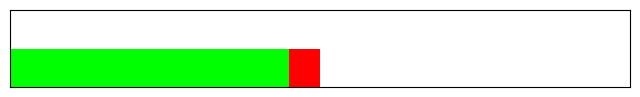

In [7]:
# plot_health_bar()  # initial bar with green size 1000
# plot_health_bar(100)  # green size 1000 + yellow size 100
plot_health_bar(-100)  # green size 900 + red size 100


In [9]:
import matplotlib.pyplot as plt

def plot_health_bar(profit):
    # Set figure size and create subplots
    fig, ax = plt.subplots(figsize=(8, 2))

    # Define colors
    green_color = '#00c853'
    yellow_color = '#000000'
    red_color = '#d50000'

    # Define bar lengths
    green_len = 1000
    yellow_len = max(0, min(profit, 1000 - green_len))
    red_len = max(0, -profit)

    # Plot bars
    ax.barh(0, green_len, color=green_color)
    ax.barh(0, yellow_len, left=green_len, color=yellow_color)
    ax.barh(0, red_len, left=1000 - red_len, color=red_color)

    # Set x-axis and y-axis limits
    ax.set_xlim([0, 2000])
    ax.set_ylim([-0.5, 0.5])

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Show plot
    plt.show()


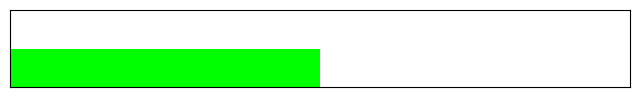

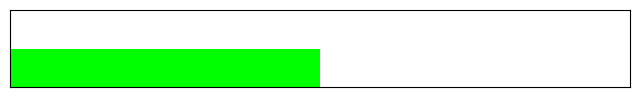

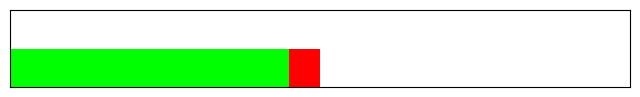

In [8]:
plot_health_bar()  # initial bar with green size 1000
plot_health_bar(100)  # green size 1000 + yellow size 100
plot_health_bar(-100)  # green size 900 + red size 100

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_health_bar(profit):
    health = 1000 
    if health > 2000:
        health = 2000
    elif health < 0:
        health = 0
        
    if profit >= 0:
        green_bar = health
        yellow_bar = health + profit
        red_bar = 0
    else:
        green_bar = health + profit
        yellow_bar = -profit
        red_bar = -profit

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.barh(0, green_bar, color='g')
    ax.barh(0, yellow_bar, color='y')
    ax.barh(0, red_bar, color='r')

    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 2000])
    ax.axis('off')

    plt.show()


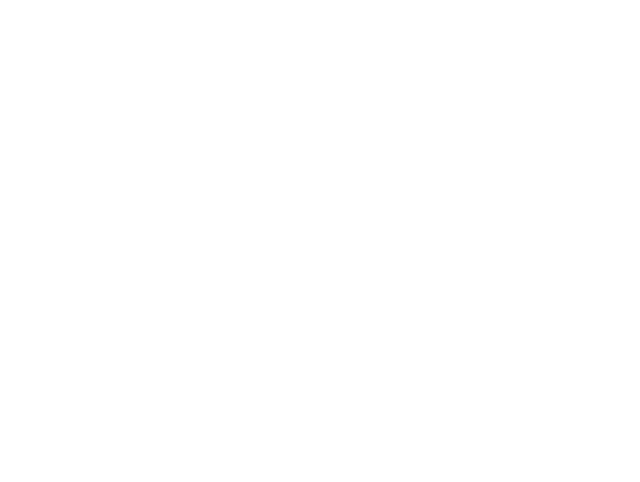

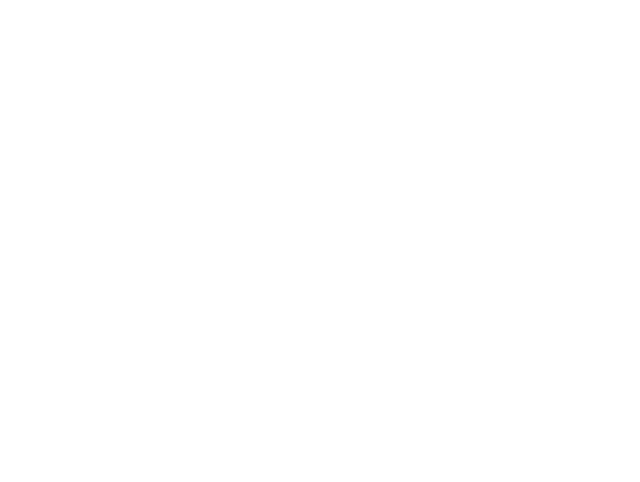

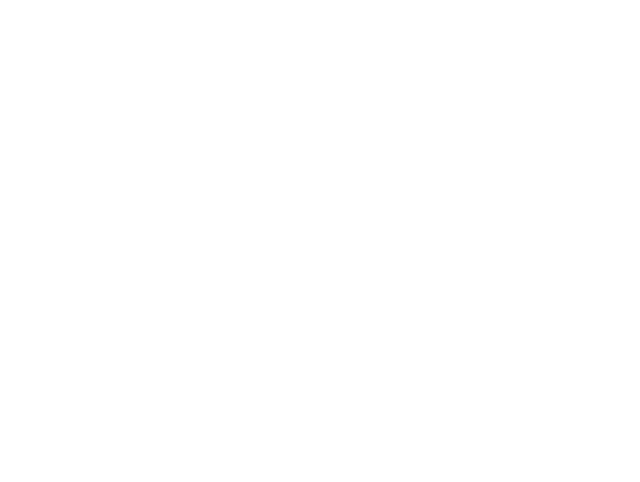

In [24]:
plot_health_bar(0)  # initial bar with green size 1000
plot_health_bar(500)  # green size 1000 + yellow size 100
plot_health_bar(-400)  # green size 900 + red size 100